In [1]:
import sqlite3
db = sqlite3.connect('./database')
db.isolation_level = None
cursor = db.cursor()

In [259]:
cursor.execute('''
    CREATE TABLE IF NOT EXISTS gene_features_all(id TEXT, trans_id TEXT, prot_id TEXT, chrom INTEGER, start INTEGER, end INTEGER, gLength INTEGER, cds INTEGER, name TEXT, exp REAL, ess REAL, evolRate REAL, dup_type TEXT)
''')
with open('lens_locs_2.txt') as source:
    source.readline()
    for line in source:
        line = line.strip().split('\t')
        gene_id, transcript_id, prot_id, chrom, start, end, CDS, name = line
        gLen = (abs(int(end)-int(start))) +1 #start and end bases are both within the gene
        cursor.execute(
                '''INSERT INTO gene_features_all(id, trans_id, prot_id, chrom, start, end, gLength, cds, name) VALUES(?,?,?,?,?,?,?,?,?)''', 
                (gene_id, transcript_id, prot_id, chrom, start, end, gLen, CDS, name))
        db.commit()

In [260]:
#essentiality
with open('Downloads/Wang_CRISPR.csv', 'r') as file:
    file.readline()
    for line in file:
        l = line.strip().split(',')
        geneName, KBM7, K562, Jiyoye, Raji = l[0], float(l[2]), float(l[4]), float(l[6]), float(l[8])
        scoreList = [KBM7, K562, Jiyoye, Raji]
        ess = min(scoreList)
        cursor.execute('''UPDATE gene_features_all SET ess = ? WHERE name == ?''', 
                       (ess, geneName))
        db.commit()

In [261]:
#evolutionary rate
count = 0
with open('Downloads/dn_ds_chimp.txt','r') as evol_file_chimp:
    evol_file_chimp.readline()
    for line in evol_file_chimp:
        count += 1
        line = line.strip().split('\t')
        if len(line) == 4:
            gene_id_ev, trans_id_ev, dn, ds = line
            if float(ds) == 0:
                rate = 0
            else:
                rate = float(dn)/float(ds)
        else:
            gene_id_ev, trans_id_ev = line
            dn = '-'
            ds = '-'
            rate = '-'
        cursor.execute('''UPDATE gene_features_all SET evolRate = ? WHERE 
                        (id == ?)''', 
                       (rate, gene_id_ev))
    db.commit()

In [ ]:
#id to tissue
cursor.execute('CREATE TABLE IF NOT EXISTS sample_att(Gtex_id TEXT, tissue TEXT)')
with open('Downloads/GTex_sample_data.txt') as sample_att_file:
    sample_att_file.readline()
    for line in sample_att_file:
        line = line.strip().split('\t')
        GTex_id, tissue = line[0], line[5]
        cursor.execute('INSERT INTO sample_att(Gtex_id, tissue) VALUES(?,?)', (GTex_id, tissue))
    db.commit()

In [29]:
#gene expression
count = 0
pcount = 0
import re
import numpy as np

cursor.execute('CREATE TABLE IF NOT EXISTS Gene_expression_data(id TEXT, name TEXT, tissue TEXT, avg_exp REAL)')

with open('Downloads/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.txt') as expression_file:
    for i in range(2):
        expression_file.readline()
    sample_ids = expression_file.readline().strip().split('\t')[2:]
    #gets where each tissue starts and ends in the sample ids
    tissue_index = {}
    old_tissue = ''
    for i in range(0,len(sample_ids)):
        cursor.execute('''SELECT tissue FROM sample_att WHERE GTex_id == ?''', (sample_ids[i],))
        tissue = cursor.fetchall()[0][0]
        if tissue == old_tissue:
            tissue_index[tissue].append(i)
        else:
            tissue_index[tissue] = [i]
            old_tissue = tissue
    #each line is a gene
    print('starting')
    for line in expression_file:
        count += 1
        av_dict = {}
        count += 1
        line = line.strip().split('\t')
        #gives the gene id without the version number
        gene = re.search(r'(.*)\.(.*)', line[0]).group(1)
        name = line[1]
        exp_values = line[2:]
        for i in range(0,len(exp_values)):
             exp_values[i] = float(exp_values[i])
        for tissue in tissue_index:
            mini = min(tissue_index[tissue])
            maxi = max(tissue_index[tissue]) + 1
            #get the average expression for each tissue
            av_dict[tissue] = np.median(exp_values[mini:maxi])
            cursor.execute('''INSERT INTO Gene_expression_data(id, name, tissue, avg_exp) VALUES (?,?,?,?)''',
                          (gene, name, tissue, av_dict[tissue]))
        if count % 2810 == 0:
            pcount += 5
            print(str(pcount) + '%')
        #need to add the expression data from other sources 
db.commit()

starting


OperationalError: near "(": syntax error

In [ ]:
#transcript expression
count = 0
pcount = 0
cursor.execute('CREATE TABLE IF NOT EXISTS Transcript_expression_data(id TEXT, trans_id TEXT, tissue TEXT, avg_exp REAL)')

with open('Downloads/GTEx_Analysis_2016-01-15_v7_RSEMv1.2.22_transcript_tpm.txt') as t_exp_file:
    #the first two items aren't ids
    sample_ids_2 = t_exp_file.readline().strip().split('\t')[2:]
    tissue_index = {}
    old_tissue = ''
    for i in range(0,len(sample_ids_2)):
        cursor.execute('''SELECT tissue FROM sample_att WHERE GTex_id == ?''', (sample_ids[i],))
        tissue = cursor.fetchall()[0][0]
        if tissue == old_tissue:
            tissue_index[tissue].append(i)
        else:
            tissue_index[tissue] = [i]
            old_tissue = tissue
    for line in t_exp_file:
        av_dict = {}
        count += 1
        line = line.strip().split('\t')        
        transcript = re.search(r'(.*)\.(.*)', line[0]).group(1)
        gene = re.search(r'(.*)\.(.*)', line[1]).group(1)
        t_exp_values = line[2:]
        for i in range(0,len(t_exp_values)):
             t_exp_values[i] = float(t_exp_values[i])
        for tissue in tissue_index:
            mini = min(tissue_index[tissue])
            maxi = max(tissue_index[tissue]) + 1
            #get the average expression for each tissue
            av_dict[tissue] = np.mean(t_exp_values[mini:maxi])
            cursor.execute('''INSERT INTO Transcript_expression_data(id, trans_id, tissue, avg_exp) VALUES (?,?,?,?)''',
                          (gene, transcript, tissue, av_dict[tissue])) 
        if count%9826 == 0:
            pcount += 5
            print(str(pcount) + '%')
db.commit()

In [281]:
cursor.execute('''SELECT COUNT(DISTINCT id) FROM gene_features_all WHERE (evolRate == 0 OR evolRate == "-")''')
print(cursor.fetchall())

[(5949,)]


In [270]:
from statistics import mode, StatisticsError
import time
cursor.execute('''CREATE TABLE IF NOT EXISTS gene_features(id TEXT, chrom INTEGER, start INTEGER, end INTEGER, 
                gLength INTEGER, cds_len INTEGER, cds_exp INTEGER, name TEXT, 
                exp REAL, ess REAL, evolRate REAL, dup_type TEXT, dev TEXT)''')
cursor.execute('''SELECT DISTINCT id FROM gene_features_all''')
count = 0
pcount = 0
id_list = []
[id_list.append(y[0]) for y in cursor.fetchall()]
query_list = []
print('starting')
t1 = time.time()
for gene_id in id_list:
    count += 1
    row_list = []
    cursor.execute('''SELECT * FROM gene_features_all WHERE id == ?''', (gene_id,))
    [row_list.append(x) for x in cursor.fetchall()]
    row1 = row_list[0]
    i,c,s,e,gL,n,es,eR,dT = row1[0], row1[3], row1[4], row1[5], row1[6], row1[8], row1[10], row1[11], row1[12]
    #cds by length
    cds_list = []
    [cds_list.append(row[7]) for row in row_list]
    cds = max(cds_list)
    cursor.execute('''SELECT avg_exp FROM Gene_expression_data WHERE id == ?''', (gene_id,))
    exp_list = []
    [exp_list.append(x[0]) for x in cursor.fetchall()]
    try:
        ex = max(exp_list)
    except ValueError:
        ex = -1
    #CDS by expression
    tList = []
    cursor.execute('''SELECT id, tissue, trans_id, MAX(avg_exp) 
                    FROM Transcript_expression_data
                    WHERE id = ?
                    GROUP BY id,tissue''',
                    (gene_id,))
    [tList.append(y[2]) for y in cursor.fetchall()]
    try:
        tt = mode(tList)
        cursor.execute('''SELECT cds FROM gene_features_all WHERE trans_id = ?''', (tt,))
        cds_e = cursor.fetchall()[0][0]
    except (IndexError, StatisticsError) as error:
        cds_e = -1
    query_list.append((i,c,s,e,gL,cds,cds_e,n,ex,es,eR,dT))
    if (count%250 == 0) or (count == len(id_list)):
        cursor.executemany('''INSERT INTO gene_features(id,chrom,start,end,gLength,cds_len,cds_exp,name,exp,ess,evolRate,dup_type) 
                    VALUES (?,?,?,?,?,?,?,?,?,?,?,?)''', query_list)
        query_list.clear()
        print(time.time()-t1)
    if count%1014 == 0:
        pcount += 5
        print(str(pcount) + '%' + ' done')
db.commit()

starting
635.4381759166718
1262.0247631072998
1884.391834974289
2505.430620908737
5% done
3124.3054060935974
3742.8106050491333
4361.413789987564
4979.523952960968
10% done
5621.419725894928
6321.52587389946
7014.365797996521
7715.520747900009
15% done
8397.515458106995
9095.19866490364
9793.084975004196
10447.31580901146
20% done
11076.027450084686
11703.624747037888
12331.253510951996
12959.032908916473
25% done
13585.660911083221
14212.110119104385
14838.145415067673
15463.204093933105
30% done
16088.090156078339
16712.52544593811
17336.91012096405
17964.470082998276
35% done
18600.17510008812
19242.171489953995
19877.183581113815
20542.92020010948
40% done
21156.398781061172
21785.615838050842
22448.54932999611
23090.75127005577
45% done
23723.3496260643
24332.68085002899
24935.235861063004
25536.698832035065
50% done
26137.39456510544
26737.58636689186
27336.265707969666
27933.643132925034
55% done
28530.880835056305
29127.561028003693
29723.399254083633
30319.195180892944
60% don

In [272]:
cursor.execute('''ALTER TABLE gene_features ADD COLUMN dev_exp REAL''')

In [273]:
# updating exp column with brain dev data
count = 0
qList = []
t1 = time.time()
with open('Downloads/brain_dev_exp.tsv', 'r') as brain_file:
    for i in range(0,4):
        brain_file.readline()
    tissues = brain_file.readline().strip().split('\t')[2:]
    old_max = 0
    for line in brain_file:
        count += 1
        values = []
        line = line.strip().split('\t')
        gene_id = line[0]
        name = line[1]
        for x in line[2:]:
            try:
                values.append(float(x)) 
            except ValueError:
                [values.append(None)]
        max_dev = max(x for x in values if x is not None)
        qList.append((max_dev, gene_id))
        if count % 500 == 0:
            print(count)
            print((time.time()-t1)/60)
            t1 = time.time()
            cursor.executemany('''UPDATE gene_features SET dev_exp = ? 
                                WHERE (id == ?) ''', qList)
            qList.clear()
    cursor.executemany('''UPDATE gene_features SET dev_exp = ? 
                        WHERE (id == ?)''', qList)
db.commit()

500
0.0011044661204020181
1000
0.05184411605199178
1500
0.048823233445485434
2000
0.048802681763966876
2500
0.047989384333292646
3000
0.047914516925811765
3500
0.04811926682790121
4000
0.04789576530456543
4500
0.047833800315856934
5000
0.04774726629257202
5500
0.04774381717046102
6000
0.048572699228922524
6500
0.04834776719411214
7000
0.04783725341161092
7500
0.04757406711578369
8000
0.04847033421198527
8500
0.048020180066426596
9000
0.04819468259811401
9500
0.04792136748631795
10000
0.04921886920928955
10500
0.04798630078633626
11000
0.04842958052953084
11500
0.04829626480738322
12000
0.048191781838734946
12500
0.04849486748377482
13000
0.047908631960550944
13500
0.04809266726175944
14000
0.04816731611887614
14500
0.047990016142527264
15000
0.04824965000152588
15500
0.04818271398544312
16000
0.04872804880142212
16500
0.048387197653452556
17000
0.051161948839823404
17500
0.04892956813176473
18000
0.04781428575515747
18500
0.0482727845509847
19000
0.048763434092203774
19500
0.0489410360

In [274]:
#fetal data (FANTOM5)
i_list = []
values = []
q_list = []
count = 0
with open('Downloads/fetal_exp.tsv', 'r') as ffile:
    for i in range(0,4):
        ffile.readline()
    header = ffile.readline().strip().split('\t')
    for i in range(0, len(header)):
        if 'fetal' in header[i]:
             i_list.append(i)
    for line in ffile:
        count += 1
        values = []
        line = line.strip().split('\t')
        gene_id = line[0]
        for n in i_list:
            try:
                values.append(line[n])
            except IndexError:
                values.append(None)
        max_val = max(x for x in values if x is not None)
        q_list.append((max_val, gene_id, max_val))
        if count % 500 == 0:
            cursor.executemany('''UPDATE gene_features 
                                SET dev_exp = ? 
                                WHERE (id ==?) AND (dev_exp < ?)''', q_list)
            q_list.clear()
            print(count)
    cursor.executemany('''UPDATE gene_features 
                        SET dev_exp = ? 
                        WHERE (id ==?) AND (dev_exp < ?)''', q_list) 

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000


In [49]:
cursor.execute('''DROP TABLE ohnologs''')
cursor.execute('''CREATE TABLE IF NOT EXISTS ohnologs(id TEXT, ohnos TEXT)''')
o_dict = {}
with open('Desktop/human_ohnologs_EnsV86.txt', 'r') as o_file:
    for line in o_file:
        line = line.strip().split('\t')
        gene, ohno = line[0], line[1]
        if gene in o_dict.keys():
            o_dict[gene].append(ohno)
        else:
            o_dict[gene] = [ohno]
for key in o_dict:
    ohnos = ' '.join(o_dict[key])
    cursor.execute('INSERT INTO ohnologs(id,ohnos) VALUES(?,?)', (key,ohnos))
# for key in o_dict:
#     try:
#         cursor.execute('SELECT id FROM gene_features_all WHERE prot_id == ?', (key,))
#         gene = cursor.fetchall()[0][0]
#     except IndexError:
#         next
#     cursor.execute('SELECT ohnos FROM ohnologs WHERE id ==?', (key,))
#     no = len(cursor.fetchall()[0][0].split(' '))
#     if no > 4:
#         print(gene, key, ' WGD:', no)

In [85]:
cursor.execute('''DROP TABLE paralogs''')
cursor.execute('''CREATE TABLE IF NOT EXISTS paralogs(id TEXT, prot TEXT, paralogs TEXT, paralogs_p TEXT)''')
pDictG = {}
pDictP = {}
cDict = {}
with open('Downloads/paralogs2.txt','r') as pFile:
    pFile.readline()
    for line in pFile:
        line = line.strip().split('\t')
        gene_id, prot_id, para_g, para_p = line[0], line[1], line[2], line[3]
        if gene_id in pDictG.keys():
            if prot_id not in cDict[gene_id]:
                cDict[gene_id].append(prot_id)
            if para_g not in pDictG[gene_id]:
                pDictG[gene_id].append(para_g)
            if para_p not in pDictP[gene_id]:
                pDictP[gene_id].append(para_p)
        else:
            cDict[gene_id] = [prot_id]
            pDictG[gene_id] = [para_g]
            pDictP[gene_id] = [para_p]
    for key in pDictG:
        paraGs = ' '.join(pDictG[key])
        paraPs = ' '.join(pDictP[key])
        prots = ' '.join(cDict[key])
        cursor.execute('''INSERT INTO paralogs(id, prot, paralogs, paralogs_p) VALUES (?,?,?,?)''', 
                       (key, prots, paraGs, paraPs))

In [50]:
cursor.execute('''ALTER TABLE ohnologs ADD COLUMN g_id TEXT''')
cursor.execute('''UPDATE ohnologs SET g_id = 
                (SELECT id FROM gene_features_all WHERE prot_id == ohnologs.id)''')

In [133]:
cursor.execute('UPDATE gene_features SET dup_type = "singleton" WHERE id NOT IN (SELECT id FROM paralogs_id)')
ids = []
cursor.execute('''SELECT id FROM gene_features WHERE dup_type != "singleton"''')
[ids.append(x[0]) for x in cursor.fetchall()]
count = 0
count_d = 0
count_check = 0
for i in ids:
    WGD = 'No'
    SSD = 'No'
    para_count = 0
    WGD_count = 0
    SSD_count = 0
    cursor.execute('SELECT paralogs_p FROM paralogs_id WHERE id ==?', (i,))
    paras = cursor.fetchall()[0][0].split(' ')
    cursor.execute('SELECT ohnos FROM ohnologs WHERE g_id == ?', (i,))
    try:
        ohnos = cursor.fetchall()[0][0].split(' ')
        for p in paras:
            para_count += 1
            if p in ohnos:
                WGD = 'Yes'
                WGD_count += 1
            elif p not in ohnos:
                SSD = 'Yes'
                SSD_count += 1
    except IndexError:
        WGD = 'No'
        SSD = 'Yes'
    if (WGD == 'Yes') and (SSD == 'Yes'):
        count += 1
        cursor.execute('''UPDATE gene_features SET dup_type = "WGD/SSD" WHERE id ==?''', (i,))
    elif WGD == 'Yes':
        cursor.execute('''UPDATE gene_features SET dup_type = "WGD" WHERE id == ?''', (i,))
    elif SSD == 'Yes':
        cursor.execute('''UPDATE gene_features SET dup_type = "SSD" WHERE id == ?''', (i,))
    else:
        print(i)
        print('Problem!')
    count_check +=1
    if count_check % 500 == 0:
        print(count_check * 100 /len(ids))
db.commit()
#             print(i)
#             print(para_count, WGD_count, SSD_count)
#         if SSD_count == 1:
#             count_d += 1
    
    
# print(count)
# print(count_d)

5.963740458015267
11.927480916030534
17.891221374045802
23.85496183206107
29.818702290076335
35.782442748091604
41.74618320610687
47.70992366412214
53.6736641221374
59.63740458015267
65.60114503816794
71.56488549618321
77.52862595419847
83.49236641221374
89.45610687022901
95.41984732824427


In [316]:
cursor.execute('''SELECT  COUNT (DISTINCT id) FROM paralogs WHERE vertebrate = "Yes"''')
print(cursor.fetchall())

[(12164,)]


In [286]:
cursor.execute('''DROP TABLE paralogs_id''')

In [131]:
ids = []
cursor.execute('''SELECT id FROM gene_features WHERE id IN (SELECT id FROM paralogs_id)''')
[ids.append(x[0]) for x in cursor.fetchall()]
count = 0
both_count = 0
WGD_count = 0
SSD_count = 0
for i in ids:
    count += 1
    WGD = 'No'
    SSD = 'No'
    para_count = 0

    cursor.execute('SELECT paralogs_p FROM paralogs_id WHERE id ==?', (i,))
    paras = cursor.fetchall()[0][0].split(' ')    
    cursor.execute('SELECT ohnos FROM ohnologs WHERE g_id == ?', (i,))
    try:
        ohnos = cursor.fetchall()[0][0].split(' ')
        for p in paras:
            para_count += 1
            if p in ohnos:
                WGD = 'Yes'
            elif p not in ohnos:
                SSD = 'Yes'
    except IndexError:
        WGD = 'No'
        SSD = 'Yes'
    if (WGD == 'Yes') and (SSD == 'Yes'):
        both_count += 1
    elif WGD == 'Yes':
        WGD_count += 1
    elif SSD == 'Yes':
        SSD_count += 1
    if count % 500 == 0:
        print(count*100/14218)
print(both_count)
print(WGD_count)
print(SSD_count)

3.516669011112674
7.033338022225348
10.550007033338023
14.066676044450697
17.58334505556337
21.100014066676046
24.616683077788718
28.133352088901393
31.650021100014065
35.16669011112674
38.683359122239416
42.20002813335209
45.71669714446476
49.233366155577436
52.75003516669011
56.26670417780279
656
3159
4569


In [11]:
names = []
e_names = []
cursor.execute('''SELECT name FROM gene_features''')
[names.append(x[0]) for x in cursor.fetchall()]
with open('Downloads/Wang_CRISPR.csv', 'r') as file:
    file.readline()
    for line in file:
        l = line.strip().split(',')
        geneName = l[0]
        e_names.append(geneName)
for n in names:
    if n not in e_names:
        cursor.execute('''UPDATE gene_features SET ess = -10 WHERE name == ?''', (n,))


In [ ]:
#check differences in IDs across GrCH37/GrCH38
with open('Downloads/Results-Homo_sapiens_Tools_IDMapper_.csv', 'r') as file1:
    file1.readline()
    count = 0
    not_exists = []
    not_exists2 = []
    for line in file1:
        line = line.strip().split(',')
        if line[0] != line[1]:
            count += 1
            not_exists.append(line[0])
            not_exists2.append(line[1])
            print('found one!')
            print(line[0], line[1])
    print('Old IDs: ' + str(len(set(not_exists))))
    print('New IDs: ' + str(len(set(not_exists2))))
with open('Downloads/Results-Homo_sapiens_Tools_IDMapper_-2.csv', 'r') as file2:
    file2.readline()
    not_exists2 = []
    not_exists = []
    for line in file2:
        line = line.strip().split(',')
        if line[0] != line[1]:
            count += 1
            not_exists.append(line[0])
            not_exists2.append(line[1])
            print('found one!')
            print(line[0], line[1])
    print('Old IDs: ' + str(len(set(not_exists))))
    print('New IDs: ' + str(len(set(not_exists2))))

In [124]:
# FIXED!!!
import json
import time
import requests
start_time = time.time()
cursor.execute('''DROP TABLE paralogs''')
cursor.execute('''CREATE TABLE IF NOT EXISTS paralogs(id TEXT, para TEXT, tax_group TEXT, vertebrate TEXT)''')
old_tax_list = ['Opisthokonta','Animalia','Bilateria', 'Chordata'] 
new_tax_list = ['Vertebrata', 'Sarcopterygii','Euteleostomi', 'Tetrapoda', 
                'Amniota', 'Mammalia', 'Theria', 'Eutheria','Boreoeutheria',  
                'Euarchontoglires', 'Primates', 'Haplorrhini', 'Simiiformes',
                'Catarrhini', 'Hominoidea', 'Hominidae','Homininae', 'Homo sapiens']

cursor.execute('''SELECT DISTINCT id FROM gene_features''')
id_list = [e[0] for e in cursor.fetchall()]
t1 = time.time()
act_count = 0
act_time = time.time()
count = 0
arg_list = []

for i in id_list:
    f_count = 0
    act_count += 1
#     while True:
#         try:
    if (time.time() - t1 <= 1) and (count == 10):
        time.sleep(2)
        t1 = time.time()
        count = 0
        url = 'http://rest.ensembl.org/homology/id/' + i + '?type=paralogues;target_species=human;sequence=none;'
        headers = {'Content-type':'application/json'}
        res = requests.get(url, headers= headers).json()
        count += 1
        # 1 entry dictionary with key 'data' that has the value of a one entry list 
        # which is a dictionary with two keys, id (value is queried id) and homologies
        # if id has no paralogs top dict structure is: {"data":[{"homologies":[],"id":"ENSG00000174059"}]}
        if res['data'][0]['homologies'] != []:
            for y in res['data'][0]['homologies']:
                para = y['target']['id']
                tax = y['taxonomy_level']
                if tax not in new_tax_list:
                    v = 'No'
                else:
                    v = 'Yes'
                arg_list.append((i,para,tax,v))
        else:
            continue
    else:
        url = 'http://rest.ensembl.org/homology/id/' + i + '?type=paralogues;target_species=human;sequence=none;'
        headers = {'Content-type':'application/json'}
        res = requests.get(url, headers= headers).json()
        count += 1
        if res['data'][0]['homologies'] != []:
            for y in res['data'][0]['homologies']:
                para = (y['target']['id'])
                tax = y['taxonomy_level']
                if tax not in new_tax_list:
                    v = 'No'
                else:
                    v = 'Yes'
                arg_list.append((i,para,tax,v))
        else:
            continue

#         except KeyError:
#             f_count += 1
#             if f_count <= 5:
#                 continue
#             else:
#                 print(res)
#                 print(i, 'GAVE UP')
#                 break
        
    if act_count%200 == 0:
        print(act_count)
        print((time.time() - act_time)/60)
        act_time = time.time()
        cursor.executemany('''INSERT INTO paralogs(id,para,tax_group,vertebrate) VALUES (?,?,?,?)''', arg_list)
        arg_list = []
    elif act_count == len(id_list):
        cursor.executemany('''INSERT INTO paralogs(id,para,tax_group,vertebrate) VALUES (?,?,?,?)''', arg_list)
        print('DONE. It took:', (time.time()-start_time)/60, 'minutes')



400
1.4999165852864584
600
1.0288402994473775
800
0.8545651833216349
1000
0.7471620321273804
1400
1.5970317522684734
1600
0.8292325655619304
1800
0.7763855655988058
2000
0.7648788332939148
2400
1.46599543094635
2600
0.8261043985684713
2800
0.7202593843142192
3000
0.6806267857551574
3200
0.6648555517196655
3400
0.6391944487889608
3600
0.6678495486577352
3800
0.735626216729482
4000
0.6969602664311727
4400
1.3516075332959494
4600
0.8359504699707031
4800
0.715131402015686
5000
0.6807707031567891
5200
0.6902540524800619
5400
0.746881381670634
5800
1.2067046682039897
6000
0.8221797347068787
6200
0.6604641159375508
6400
0.709081482887268
6600
0.7772870818773906
6800
0.771292265256246
7200
1.3118518352508546
7400
0.842841919263204
7600
0.6810350815455118
7800
0.8572557171185812
8400
2.2232659180959065
8600
0.921403682231903
8800
0.65737224817276
9200
1.3347592989603678
9400
1.0363859494527181
9600
0.8588784694671631
9800
0.7963651657104492
10000
0.7631242195765178
10200
0.7037003636360168
1040

In [130]:
# FIXED!!!
cursor.execute('''UPDATE gene_features SET dup_type = NULL''')
cursor.execute('''UPDATE gene_features SET dup_type = "singleton" WHERE id NOT IN 
                (SELECT id FROM paralogs WHERE vertebrate = "Yes")''')

cursor.execute('''SELECT id FROM gene_features WHERE dup_type IS NULL''')
ids = [x[0] for x in cursor.fetchall()]
count, t = 0, time.time()

for i in ids:
    WGD = 'No'
    SSD = 'No'
    cursor.execute('SELECT para FROM paralogs WHERE id ==? AND vertebrate = "Yes"', (i,))
    paras = [x[0] for x in cursor.fetchall()]
    cursor.execute('SELECT ohno_id FROM ohnologs_gene_ids WHERE id == ? AND vertebrate = "Yes"', (i,))
    res = cursor.fetchall()
    if res == []:
        WGD = 'No'
        SSD = 'Yes'
    else:
        ohnos = [x[0] for x in res]
        for p in paras:
            if p in ohnos:
                WGD = 'Yes'
            else:
                SSD = 'Yes'
    if (WGD == 'Yes') and (SSD == 'Yes'):
        cursor.execute('''UPDATE gene_features SET dup_type = "WGD/SSD" WHERE id ==?''', (i,))
    elif WGD == 'Yes':
        cursor.execute('''UPDATE gene_features SET dup_type = "WGD" WHERE id == ?''', (i,))
    elif SSD == 'Yes':
        cursor.execute('''UPDATE gene_features SET dup_type = "SSD" WHERE id == ?''', (i,))
    else:
        print(i)
        print('Problem!')
    count +=1
    if count % 500 == 0:
        print(count, 'done:', round(time.time()-t, 2), 'seconds') 

500 done: 30.21 seconds
1000 done: 59.15 seconds
1500 done: 85.0 seconds
2000 done: 110.52 seconds
2500 done: 136.78 seconds
3000 done: 162.49 seconds
3500 done: 189.52 seconds
4000 done: 214.81 seconds
4500 done: 240.67 seconds
5000 done: 267.34 seconds
5500 done: 292.85 seconds
6000 done: 318.12 seconds
6500 done: 343.78 seconds
7000 done: 369.16 seconds
7500 done: 394.45 seconds
8000 done: 420.71 seconds
8500 done: 447.82 seconds
9000 done: 473.5 seconds
9500 done: 499.46 seconds
10000 done: 524.93 seconds
10500 done: 550.18 seconds
11000 done: 575.72 seconds
11500 done: 602.44 seconds
12000 done: 630.34 seconds


In [131]:
db.commit()

In [132]:
cursor.execute('''SELECT COUNT (*) FROM gene_features WHERE dup_type = "singleton"''')
print('Singletons:', cursor.fetchall()[0][0])

cursor.execute('''SELECT COUNT (*) FROM gene_features WHERE dup_type = "SSD"''')
print('Small scale duplicates:', cursor.fetchall()[0][0])

cursor.execute('''SELECT COUNT (*) FROM gene_features WHERE dup_type = "WGD"''')
print('Ohnologs:', cursor.fetchall()[0][0])

cursor.execute('''SELECT COUNT (*) FROM gene_features WHERE dup_type = "WGD/SSD"''')
print("Things that shouldn't be:", cursor.fetchall()[0][0])

Singletons: 8116
Small scale duplicates: 6095
Ohnologs: 4904
Things that shouldn't be: 1162


In [237]:
cursor.execute('''SELECT DISTINCT COUNT(id) FROM gene_features 
                    WHERE id IN (SELECT id FROM paralogs WHERE vertebrate = "No") 
                    AND dup_type = "singleton"''')
cursor.fetchall()

[(3703,)]

In [307]:
cursor.execute('''SELECT * FROM ohnologs''')
count = 0
g_ohnos = []
forList = cursor.fetchall()
for x in forList:
    count += 1
    f = x[2]
    ohnos = x[1].split(' ')
    for e in ohnos:
        cursor.execute('''SELECT id FROM gene_features_all WHERE prot_id = ?''', (e,))
        try:
            g_e = cursor.fetchall()[0][0]
        except IndexError:
            print('Protein not found:', e)
        cursor.execute('''SELECT * FROM paralogs WHERE id = ? AND para = ? AND vertebrate = "No"''', (f,e))
        early_ohno_pairs = cursor.fetchall()
        if early_ohno_pairs != []:
            print(f, early_ohno_pairs)
    if count % 700 == 0:
        print((count/len(forList))*100, '% done')

Protein not found: ENSP00000443191
Protein not found: ENSP00000341867
10.534236267870579 % done
Protein not found: ENSP00000341867
21.068472535741158 % done
Protein not found: ENSP00000341867
31.60270880361174 % done
42.136945071482316 % done
Protein not found: ENSP00000361672
Protein not found: ENSP00000484912
52.6711813393529 % done
63.20541760722348 % done
73.73965387509406 % done
Protein not found: ENSP00000361672
84.27389014296463 % done
Protein not found: ENSP00000361672
94.80812641083521 % done


In [376]:
mix_ids = []
o_count = 0
prob_count = 0
cursor.execute('''SELECT id FROM gene_features''')
[mix_ids.append(x[0]) for x in cursor.fetchall()]
for i in mix_ids:
    cursor.execute('''SELECT COUNT (*) FROM paralogs WHERE id = ? AND vertebrate = "Yes"''', (i,))
    try:
        para_count = cursor.fetchone()[0]
    except IndexError:
        para_count = 0
    cursor.execute('''SELECT COUNT (*) FROM ohnologs_gene_ids WHERE id = ?''', (i,))
    try:
        o_count = cursor.fetchone()[0]
    except IndexError:
        o_count = 0
    if o_count > 4:
        prob_count += 1
        print(i, para_count, o_count)
    
print(prob_count)

ENSG00000143320 5 5
ENSG00000134183 5 5
ENSG00000173369 11 9
ENSG00000179546 5 5
ENSG00000132692 7 7
ENSG00000168243 8 5
ENSG00000188004 9 6
ENSG00000070886 13 13
ENSG00000126091 7 7
ENSG00000116329 10 10
ENSG00000187513 15 8
ENSG00000170128 8 8
ENSG00000135773 8 5
ENSG00000132702 7 7
ENSG00000133216 13 13
ENSG00000196189 12 5
ENSG00000162909 8 5
ENSG00000243284 9 6
ENSG00000185278 11 10
ENSG00000082482 5 5
ENSG00000159189 11 9
ENSG00000162444 5 5
ENSG00000170075 6 6
ENSG00000203697 8 5
ENSG00000117152 9 7
ENSG00000117069 5 5
ENSG00000174502 9 5
ENSG00000121634 15 8
ENSG00000184005 5 5
ENSG00000119535 6 5
ENSG00000050628 7 7
ENSG00000143537 14 5
ENSG00000065135 5 5
ENSG00000143248 9 7
ENSG00000172380 8 5
ENSG00000183317 13 13
ENSG00000143333 9 6
ENSG00000171488 6 5
ENSG00000171492 6 5
ENSG00000081985 6 5
ENSG00000265107 15 8
ENSG00000143127 10 7
ENSG00000171517 10 10
ENSG00000198835 15 8
ENSG00000135824 9 6
ENSG00000143167 9 7
ENSG00000197147 6 5
ENSG00000171812 11 9
ENSG00000181773 10

In [126]:
# FIXED!!!!!
cursor.execute('''DROP TABLE ohnologs_gene_ids''')
cursor.execute('''CREATE TABLE IF NOT EXISTS ohnologs_gene_ids(id TEXT, ohno_id TEXT, tax_group TEXT, vertebrate TEXT)''')
cursor.execute('''SELECT * FROM ohnologs''')
count, t = 0, time.time()
for y in cursor.fetchall():
    ID = y[2]
    ohno_p = y[1].split(' ')
    for o in ohno_p:
        cursor.execute('''SELECT id FROM gene_features_all WHERE prot_id = ?''', (o,))
        try:
            o_ID = cursor.fetchall()[0][0]
        except IndexError:
            print(o)
            continue
        cursor.execute('''SELECT tax_group, vertebrate FROM paralogs WHERE (id == ? AND para == ?) OR (para == ? AND id == ?)''', (ID, o_ID, ID, o_ID))
        try:
            tax, vert = cursor.fetchall()[0]
            cursor.execute('''INSERT INTO ohnologs_gene_ids(id,ohno_id, tax_group, vertebrate) VALUES (?,?,?,?)''', (ID, o_ID, tax, vert))
        except IndexError:
            print(ID, o_ID)
    count += 1
    if count % 200 == 0:
        print(count, time.time()-t)


ENSG00000134873 ENSG00000013297
ENSG00000122574 ENSG00000115935
ENSG00000092758 ENSG00000124749
ENSG00000183484 ENSG00000126266
ENSG00000147145 ENSG00000186912
ENSG00000147145 ENSG00000175591
ENSG00000147145 ENSG00000171631
ENSG00000147145 ENSG00000144230
ENSG00000147145 ENSG00000169508
ENSG00000147145 ENSG00000173198
ENSG00000147145 ENSG00000152207
200 38.27836990356445
ENSG00000137699 ENSG00000141569
ENSG00000137699 ENSG00000121060
ENSG00000133216 ENSG00000183317
ENSG00000133216 ENSG00000142627
ENSG00000133216 ENSG00000146904
ENSG00000066405 ENSG00000013297
ENSG00000163145 ENSG00000173372
ENSG00000163145 ENSG00000173918
ENSG00000138650 ENSG00000240764
ENSG00000198835 ENSG00000183153
ENSG00000138075 ENSG00000143921
ENSG00000138131 ENSG00000164099
ENSG00000138131 ENSG00000179954
ENSG00000138131 ENSG00000073754
ENSG00000138131 ENSG00000187908
ENSG00000138131 ENSG00000146700
ENSG00000196411 ENSG00000183317
ENSG00000196411 ENSG00000142627
ENSG00000196411 ENSG00000146904
ENSG00000242419 EN

ENSG00000173372 ENSG00000123500
ENSG00000173372 ENSG00000182447
ENSG00000173372 ENSG00000145861
ENSG00000173372 ENSG00000163145
None ENSG00000078487
ENSG00000164007 ENSG00000171217
ENSG00000150527 ENSG00000125879
ENSG00000108846 ENSG00000091262
ENSG00000171475 ENSG00000115935
ENSG00000265107 ENSG00000183153
ENSG00000121743 ENSG00000183153
ENSG00000163347 ENSG00000171217
2800 536.5383789539337
ENSP00000361672
ENSG00000071991 ENSG00000179776
ENSG00000070182 ENSG00000165959
None ENSG00000184811
None ENSG00000224982
None ENSG00000152611
3000 571.4575669765472
ENSG00000179930 ENSG00000168813
ENSG00000049089 ENSG00000124749
ENSG00000187513 ENSG00000183153
ENSG00000043093 ENSG00000150401
ENSG00000257108 ENSG00000169871
ENSG00000131686 ENSG00000167434
ENSG00000175591 ENSG00000147138
ENSG00000175591 ENSG00000139679
ENSG00000175591 ENSG00000147145
ENSG00000175591 ENSG00000184574
ENSG00000164099 ENSG00000138131
ENSG00000164099 ENSG00000134013
ENSG00000164099 ENSG00000115318
ENSG00000164099 ENSG00

ENSG00000113555 ENSG00000242419
ENSG00000169635 ENSG00000179456
ENSG00000169635 ENSG00000179627
ENSG00000169635 ENSG00000185670
ENSG00000169635 ENSG00000168795
ENSG00000169635 ENSG00000184828
ENSG00000169635 ENSG00000178951
ENSG00000169635 ENSG00000160685
None ENSG00000118689
None ENSG00000150907
None ENSG00000184481
ENSG00000248383 ENSG00000189184
ENSG00000248383 ENSG00000113555
ENSG00000248383 ENSG00000136099
ENSG00000248383 ENSG00000240184
ENSG00000248383 ENSG00000165194
ENSG00000248383 ENSG00000118946
5400 1028.7556719779968
ENSG00000114948 ENSG00000134028
ENSG00000114948 ENSG00000168619
ENSG00000181885 ENSG00000171217
ENSG00000143167 ENSG00000188004
ENSG00000149575 ENSG00000149573
ENSG00000149575 ENSG00000197965
ENSG00000149575 ENSG00000158887
ENSG00000149575 ENSG00000160588
ENSG00000169313 ENSG00000169403
None ENSG00000136930
ENSG00000147138 ENSG00000186912
ENSG00000147138 ENSG00000175591
ENSG00000147138 ENSG00000171631
ENSG00000147138 ENSG00000144230
ENSG00000147138 ENSG00000169

In [127]:
db.commit()

In [369]:
cursor.execute('''SELECT COUNT (DISTINCT id) FROM ohnologs_gene_ids''')
cursor.fetchall()

[(6049,)]

In [397]:
# cursor.execute('''CREATE TABLE IF NOT EXISTS ohnologs_t(id TEXT, ohno_id TEXT)''')
# with open('Downloads/takashi_ohnologs.csv', 'r') as file:
#     print(file.readline())
#     print(file.readline())
#     for line in file:
#         line = line.strip().split(',')
#         cursor.execute('''INSERT INTO t_ohnologs(id, ohno_id) VALUES(?,?)''', (line[0], line[3]))
#     db.commit()
cursor.execute('''UPDATE gene_features SET dup_type_t = "-"''')
cursor.execute('''UPDATE gene_features SET dup_type_t = "singleton" WHERE id NOT IN 
                (SELECT id FROM paralogs WHERE vertebrate = "Yes")''')
ids = []

cursor.execute('''SELECT id FROM gene_features WHERE dup_type_t != "singleton"''')
[ids.append(x[0]) for x in cursor.fetchall()]

count = 0
count_d = 0
count_check = 0
for i in ids:
    WGD = 'No'
    SSD = 'No'
    paras = []
    ohnos = []
    cursor.execute('SELECT para FROM paralogs WHERE id ==? AND vertebrate = "Yes"', (i,))
    [paras.append(x[0]) for x in cursor.fetchall()]
    cursor.execute('SELECT ohno_id FROM t_ohnologs WHERE id == ?', (i,))
    try:
        [ohnos.append(x[0]) for x in cursor.fetchall()]        
        for p in paras:
            if p in ohnos:
                WGD = 'Yes'
                WGD_count += 1
            elif p not in g_ohnos:
                SSD = 'Yes'
                SSD_count += 1
    except IndexError:
        WGD = 'No'
        SSD = 'Yes'
    if (WGD == 'Yes') and (SSD == 'Yes'):
        count += 1
        cursor.execute('''UPDATE gene_features SET dup_type_t = "WGD/SSD" WHERE id ==?''', (i,))
    elif WGD == 'Yes':
        cursor.execute('''UPDATE gene_features SET dup_type_t = "WGD" WHERE id == ?''', (i,))
    elif SSD == 'Yes':
        cursor.execute('''UPDATE gene_features SET dup_type_t = "SSD" WHERE id == ?''', (i,))
    else:
        print(i)
        print('Problem!')
    count_check +=1
    if count_check % 500 == 0:
        print(count_check * 100 /len(ids))

4.110489970404473
8.220979940808945
12.331469911213416
16.44195988161789
20.55244985202236
24.662939822426832
28.773429792831305
32.88391976323578
36.994409733640246
41.10489970404472
45.21538967444919
49.325879644853664
53.43636961525814
57.54685958566261
61.65734955606708
65.76783952647156
69.87832949687603
73.98881946728049
78.09930943768497
82.20979940808944
86.32028937849391
90.43077934889838
94.54126931930286
98.65175928970733


In [11]:
cursor.execute('''ALTER TABLE gene_features ADD COLUMN w_exp REAL''') 

In [164]:
# FIXED!!!
cursor.execute('''DROP TABLE macaque_paralogs''')
cursor.execute('''CREATE TABLE IF NOT EXISTS macaque_paralogs(id TEXT, m_id TEXT, dn_ds REAL)''')
import requests, json, time
from requests import ConnectTimeout, ReadTimeout
cursor.execute('''SELECT id FROM gene_features''')
ids = [x[0] for x in cursor.fetchall()]

timer = time.time()
count, counter = 0, 0
t = time.time()
values = []
fails = []
for i in ids:
    orth_dict = {}
    if (time.time()-t <= 1) and (count >= 14):
        time.sleep(1)
        t = time.time()
        count = 0
        url = 'http://rest.ensembl.org/homology/id/' + i + '?type=orthologues;target_species=macaque;sequence=none;'
        headers = {'Content-type':'application/json'}
        try:
            r = requests.get(url, headers=headers, timeout=5)
        except (ConnectTimeout, ReadTimeout) as e:
            fails.append(i)
            continue
        if r.status_code == 500:
            fails.append(i)
            continue
        res = r.json()
        if res['data'][0]['homologies'] != []:
            orth_dict = res['data'][0]['homologies']
        else:
            continue
        if len(orth_dict) == 1:
            for x in orth_dict:
                m_id = x['target']['id']
                dnds = x['dn_ds']
                values.append((i, m_id, dnds))
            
    else:
        url = 'http://rest.ensembl.org/homology/id/' + i + '?type=orthologues;target_species=macaque;sequence=none;'
        headers = {'Content-type':'application/json'}
        try:
            r = requests.get(url, headers=headers, timeout=5)
        except (ConnectTimeout, ReadTimeout) as e:
            fails.append(i)
            continue        
        if r.status_code == 500:
            fails.append(i)
            continue
        res = r.json()
        if res['data'][0]['homologies'] != []:
            orth_dict = res['data'][0]['homologies']
        else:
            continue
        if len(orth_dict) == 1:
            for x in orth_dict:
                m_id = x['target']['id']
                dnds = x['dn_ds']
                values.append((i, m_id, dnds))
    count += 1  
    counter += 1
    if (counter % 500 == 0) or (counter == len(ids)):
        print(counter, time.time()- timer)
        timer = time.time()
        cursor.executemany('''INSERT INTO macaque_paralogs(id,m_id,dn_ds) VALUES (?,?,?)''', values)
        values.clear()
db.commit()
print('Retrying failed requests...', len(fails))
while len(fails) != 0:
    for i in fails:
        url = 'http://rest.ensembl.org/homology/id/' + i + '?type=orthologues;target_species=macaque;sequence=none;'
        headers = {'Content-type':'application/json'}
        try:
            r = requests.get(url, headers=headers, timeout=5)
        except (ConnectTimeout, ReadTimeout) as e:
            continue
        if r.status_code == 500:
            continue
        if r.status_code == 429:
            time.sleep(5)
            continue
        res = r.json()
        fails.remove(i)
        if res['data'][0]['homologies'] != []:
            orth_dict = res['data'][0]['homologies']
        else:
            continue
        if len(orth_dict) == 1:
            for x in orth_dict:
                m_id = x['target']['id']
                dnds = x['dn_ds']
                cursor.execute('''INSERT INTO macaque_paralogs(id,m_id,dn_ds) VALUES (?,?,?)''', (i, m_id,dnds))

db.commit()

500 82.95765709877014
1000 83.45081996917725
1500 86.67040514945984
2000 83.07139492034912
2500 87.50446891784668
3000 90.01358890533447
3500 107.72533392906189
4000 110.1339259147644
4500 105.85418009757996
5000 112.99159812927246
5500 107.62624788284302
6000 116.20747995376587
6500 100.40454411506653
7000 88.19193696975708
7500 89.90537095069885
8000 91.25322198867798
8500 89.06080389022827
9000 92.56842803955078
9500 168.97749996185303
10000 89.0463399887085
10500 90.758141040802
11000 91.83365082740784
11500 86.21999883651733
12000 82.47376894950867
12500 87.07252907752991
13000 91.85354995727539
13500 87.27619194984436
14000 88.44925594329834
14500 87.65625
15000 90.04268383979797
15500 88.76708698272705
16000 86.65396285057068
16500 85.96212100982666
17000 85.15207290649414
Retrying failed requests... 13


In [159]:
len(fails)

17

In [14]:
db.commit()
cursor.close()
db.close()

In [ ]:
#gene expression (fix- setting as median)
count = 0
pcount = 0
import re
import numpy as np
import time
t1 = time.time()
cursor.execute('''BEGIN TRANSACTION''')
cursor.execute('CREATE TABLE IF NOT EXISTS Gene_expression_data(id TEXT, name TEXT, tissue TEXT, avg_exp REAL)')
cursor.execute('''COMMIT''')
with open('Downloads/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.txt') as expression_file:
    for i in range(2):
        expression_file.readline()
    sample_ids = expression_file.readline().strip().split('\t')[2:]
    #gets where each tissue starts and ends in the sample ids
    tissue_index = {}
    old_tissue = ''
    for i in range(0,len(sample_ids)):
        #get the tissue corresponding to each id, make a dictionary of which indexes in the line belong to each tissue
        cursor.execute('''BEGIN TRANSACTION''')
        cursor.execute('''SELECT tissue FROM sample_att WHERE GTex_id == ?''', (sample_ids[i],))
        tissue = cursor.fetchall()[0][0]
        cursor.execute('''COMMIT''')
        if tissue == old_tissue:
            tissue_index[tissue].append(i)
        else:
            tissue_index[tissue] = [i]
            old_tissue = tissue
    print(time.time()-t1)
    #each line is a gene
    update_count = 0
    val_list = []
    pcount = 0
    print('starting')
    t = time.time()
    for line in expression_file:
        count += 1
        av_dict = {}
        line = line.strip().split('\t')
        #gives the gene id without the version number
        gene = re.search(r'(.*)\.(.*)', line[0]).group(1)
        exp_values = line[2:]
        for i in range(0,len(exp_values)):
             exp_values[i] = float(exp_values[i])
        for tissue in tissue_index:
            mini = min(tissue_index[tissue])
            maxi = max(tissue_index[tissue]) + 1
            #get the average expression for each tissue
            av_dict[tissue] = np.median(exp_values[mini:maxi])
            cursor.execute('''BEGIN TRANSACTION''')
            cursor.execute('''UPDATE Gene_expression_data SET avg_exp = ? WHERE id == ? AND tissue == ?''', (av_dict[tissue], gene, tissue))
            cursor.execute('''COMMIT''')
        if count % 200 == 0:  
            print(str(count), time.time() - t)
            t = time.time()
        #need to add the expression data from other sources 
db.commit()

49.84485101699829
starting
200 3138.00630903244
400 3116.563446044922
600 3120.882938146591
800 3111.3546059131622
1000 3109.666086912155
1200 3110.403367996216
1400 3109.669158935547
1600 3110.517269849777
1800 3111.057408809662
2000 3110.7360548973083
2200 3110.046371936798
2400 3110.7923460006714
2600 3110.9394669532776
2800 3111.5114040374756
3000 3110.6562011241913
3200 3109.270812034607
3400 3110.3184311389923
3600 3109.6065690517426
3800 3110.827378988266
4000 3110.777886867523
4200 3110.2127141952515
4400 3113.10306596756
4600 3118.8885300159454
4800 3110.167349100113
5000 3110.654494047165
5200 3110.3967978954315
5400 3110.756507873535
5600 3110.8870599269867
5800 3108.883094072342
6000 3109.8299939632416
6200 3111.7050189971924
6400 3113.800707101822
6600 3110.1287751197815
6800 3111.2369141578674
7000 3109.739989042282
7200 3111.5417630672455
7400 3107.232134103775
7600 3110.9773919582367
7800 3111.856598854065
8000 3110.910651922226
8200 3109.568344116211
8400 3111.18384504

KeyboardInterrupt: 

In [ ]:
#transcript expression (fix)
count = 0
cursor.execute('CREATE TABLE IF NOT EXISTS Transcript_expression_data(id TEXT, trans_id TEXT, tissue TEXT, avg_exp REAL)')

with open('Downloads/GTEx_Analysis_2016-01-15_v7_RSEMv1.2.22_transcript_tpm.txt') as t_exp_file:
    #the first two items aren't ids
    sample_ids_2 = t_exp_file.readline().strip().split('\t')[2:]
    tissue_index = {}
    old_tissue = ''
    for i in range(0,len(sample_ids_2)):
        cursor.execute('''SELECT tissue FROM sample_att WHERE GTex_id == ?''', (sample_ids[i],))
        tissue = cursor.fetchall()[0][0]
        if tissue == old_tissue:
            tissue_index[tissue].append(i)
        else:
            tissue_index[tissue] = [i]
            old_tissue = tissue
    for line in t_exp_file:
        t = time.time()
        av_dict = {}
        count += 1
        line = line.strip().split('\t')        
        transcript = re.search(r'(.*)\.(.*)', line[0]).group(1)
        gene = re.search(r'(.*)\.(.*)', line[1]).group(1)
        t_exp_values = line[2:]
        for i in range(0,len(t_exp_values)):
             t_exp_values[i] = float(t_exp_values[i])
        for tissue in tissue_index:
            mini = min(tissue_index[tissue])
            maxi = max(tissue_index[tissue]) + 1 #because of 'up to but not including' in list slicing
            #get the average expression for each tissue
            av_dict[tissue] = np.median(t_exp_values[mini:maxi])
            val_list.append((av_dict[tissue], transcript, tissue))
        if count % 500 == 0:
            cursor.executemany('''UPDATE Transcript_expression_data SET avg_exp = ? WHERE trans_id = ? AND tissue = ?''', val_list)
            print(str(count), time.time()-t)
            t = time.time()
            val_list.clear()
    cursor.executemany('''UPDATE Transcript_expression_data SET avg_exp = ? WHERE trans_id = ? AND tissue = ?''', val_list)

db.commit()

In [28]:
cursor.execute('''ALTER TABLE gene_features ADD COLUMN unique_domains INTEGER''')

In [ ]:
# unique protein domains
# FIX!!!
import requests, json, time

cursor.execute('''SELECT DISTINCT id FROM gene_features_all''')
gene_list = [x[0] for x in cursor.fetchall()]
actual_count = 0
fails = []
t1 = time.time()
t = time.time()
count = 0
for g in gene_list:
    actual_count += 1
    dom_list = []
    cursor.execute('''SELECT prot_id FROM gene_features_all WHERE id =?''', (g,))
    prot_list = [x[0] for x in cursor.fetchall()]
    try:
        for p in prot_list:
            u_time = time.time()
            count += 1
            if time.time() - t <= 1 and count >= 10:
                time.sleep(1)
                t = time.time()
                count = 0
                url = "https://rest.ensembl.org/overlap/translation/" + p + "?type=Pfam"
                headers = { "Content-Type" : "application/json"}
                r = requests.get(url, headers=headers, timeout=5).json()
                if r != []:
                    [dom_list.append(x['id']) for x in r]
                else:
                    continue
            else:
                url = "https://rest.ensembl.org/overlap/translation/" + p + "?type=Pfam"
                headers = { "Content-Type" : "application/json"}
                r = requests.get(url, headers=headers).json()
                if r != []:
                    [dom_list.append(x['id']) for x in r]
                else:
                    continue
    except:
        fails.append(g)
        continue
    u = len(set(dom_list))
    cursor.execute('''UPDATE gene_features SET unique_domains = ? WHERE id = ?''', (u, g))
    if actual_count % 100 == 0:
        print(actual_count, ':', time.time()-t1, 'seconds')
print('Retrying failed requests...', len(fails))
ti = time.time()
while len(fails) != 0:
    for g in fails:
        dom_list = []
        cursor.execute('''SELECT prot_id FROM gene_features_all WHERE id =?''', (g,))
        prot_list = [x[0] for x in cursor.fetchall()]
        try:
            for p in prot_list:
                if time.time() - t <= 1 and count >= 10:
                    time.sleep(1)
                    t = time.time()
                    count = 0
                    url = "https://rest.ensembl.org/overlap/translation/" + p + "?type=Pfam"
                    headers = { "Content-Type" : "application/json"}
                    r = requests.get(url, headers=headers, timeout=5).json()
                    fails.remove(g)
                    if r != []:
                        [dom_list.append(x['id']) for x in r]
                    else:
                        continue
                else:
                    url = "https://rest.ensembl.org/overlap/translation/" + p + "?type=Pfam"
                    headers = { "Content-Type" : "application/json"}
                    r = requests.get(url, headers=headers).json()
                    fails.remove(g)
                    if r != []:
                        [dom_list.append(x['id']) for x in r]
                    else:
                        continue
        except:
            continue
        u = len(set(dom_list))
        cursor.execute('''UPDATE gene_features SET unique_domains = ? WHERE id = ?''', (u, g))
    if time.time()-ti > 600:
        break
if len(fails) != 0:
    print(fails)
db.commit()

100 : 141.6885290145874 seconds
200 : 249.9753270149231 seconds
300 : 403.92314291000366 seconds
400 : 563.4107549190521 seconds
500 : 664.8946278095245 seconds
600 : 777.9088838100433 seconds
700 : 937.7625420093536 seconds
800 : 1059.8378729820251 seconds
900 : 1170.4990599155426 seconds
1000 : 1303.4719529151917 seconds
1100 : 1434.9682838916779 seconds
1200 : 1600.3768589496613 seconds
1300 : 1712.7901699543 seconds
1400 : 1849.521010875702 seconds
1500 : 2004.4953718185425 seconds
1600 : 2134.59881401062 seconds
1700 : 2253.6701259613037 seconds
1800 : 2374.450325012207 seconds
1900 : 2499.1329839229584 seconds
2000 : 2625.1797449588776 seconds
2100 : 2790.4908039569855 seconds
2200 : 3048.5255739688873 seconds
2300 : 3276.785439014435 seconds
2400 : 3446.772720813751 seconds
2500 : 3573.165820837021 seconds
2600 : 3690.1888270378113 seconds
2700 : 3816.826020002365 seconds
2800 : 3966.130014896393 seconds
2900 : 4116.7679970264435 seconds
3000 : 4253.371701955795 seconds
3100 : 4

In [194]:
cursor.execute('''ALTER TABLE gene_features ADD COLUMN domains INTEGER''')

In [ ]:
#absolute number of protein domains (mapped from protein coordinates to genomic coordinates)
# FIX!!!
import itertools
cursor.execute('''SELECT DISTINCT id FROM gene_features_all''')
gene_list = [x[0] for x in cursor.fetchall()]
fails = []
actual_count = 0
t = time.time()
timer = time.time()
count = 0
counter = 0
for g in gene_list:
    counter += 1
    domain_list = []
    list_count = -1
    
    cursor.execute('''SELECT prot_id FROM gene_features_all WHERE id =?''', (g,))
    prot_list = [x[0] for x in cursor.fetchall()]
    try:
        for p in prot_list:
            count += 1

            if time.time() - t <= 1 and count >= 15:

                time.sleep(1)
                t = time.time()
                count = 0

                url = "https://rest.ensembl.org/overlap/translation/" + p + "?type=Pfam"
                headers = { "Content-Type" : "application/json"}
                r = requests.get(url, headers=headers).json()

                if r != []:
                    #go through all domains in the protein
                    for y in r:
                        count += 1
                        list_count += 1
                        s, e, d = y['start'], y['end'], y['id']
                        url2 = "https://rest.ensembl.org/map/translation/" + p + "/" + str(s) + ".." + str(e) + "?"
                        r2 = requests.get(url2, headers=headers).json()
                        #go through all the genomic coordinates the domain maps to
                        domain_list.append([d])
                        for z in r2['mappings']:
                            start = min(z['start'], z['end'])
                            end = max(z['start'], z['end'])
                            domain_list[list_count].append((start, end))


                else:
                    continue

            elif time.time()-t > 1:

                t = time.time()
                count = 0

                url = "https://rest.ensembl.org/overlap/translation/" + p + "?type=Pfam"
                headers = { "Content-Type" : "application/json"}
                r = requests.get(url, headers=headers).json()

                if r != []:
                    for y in r:
                        count += 1
                        list_count += 1
                        s, e, d = y['start'], y['end'], y['id']
                        url2 = "https://rest.ensembl.org/map/translation/" + p + "/" + str(s) + ".." + str(e) + "?"
                        r2 = requests.get(url2, headers=headers).json()
                        #go through all the genomic coordinates the domain maps to
                        domain_list.append([d])
                        for z in r2['mappings']:
                            start = min(z['start'], z['end'])
                            end = max(z['start'], z['end'])
                            domain_list[list_count].append((start, end))
                else:
                    continue
            else:

                url = "https://rest.ensembl.org/overlap/translation/" + p + "?type=Pfam"
                headers = { "Content-Type" : "application/json"}
                r = requests.get(url, headers=headers).json()
                if r != []:
                    for y in r:
                        list_count += 1
                        count += 1
                        s, e, d = y['start'], y['end'], y['id']
                        url2 = "https://rest.ensembl.org/map/translation/" + p + "/" + str(s) + ".." + str(e) + "?"
                        r2 = requests.get(url2, headers=headers).json()
                        #go through all the genomic coordinates the domain maps to
                        domain_list.append([d])
                        for z in r2['mappings']:
                            start = min(z['start'], z['end'])
                            end = max(z['start'], z['end'])
                            domain_list[list_count].append((start, end))
                else:
                    continue
    except:
        fails.append(g)
        continue
    no_domains = merge_domains(domain_list)
    cursor.execute('''UPDATE gene_features SET domains = ? WHERE id == ?''', (no_domains, g))
    
    if counter % 100 == 0:
        print(counter, "done:", time.time()-timer, "seconds")
print('Retrying failed requests...', len(fails))
retry_start = time.time()
while len(fails) != 0:
    for g in fails:
        list_count = -1

        cursor.execute('''SELECT prot_id FROM gene_features_all WHERE id =?''', (g,))
        prot_list = [x[0] for x in cursor.fetchall()]
        try:
            for p in prot_list:

                url = "https://rest.ensembl.org/overlap/translation/" + p + "?type=Pfam"
                headers = { "Content-Type" : "application/json"}
                r = requests.get(url, headers=headers).json()
                if r != []:
                    for y in r:
                        list_count += 1
                        count += 1
                        s, e, d = y['start'], y['end'], y['id']
                        url2 = "https://rest.ensembl.org/map/translation/" + p + "/" + str(s) + ".." + str(e) + "?"
                        r2 = requests.get(url2, headers=headers).json()
                        #go through all the genomic coordinates the domain maps to
                        domain_list.append([d])
                        for z in r2['mappings']:
                            start = min(z['start'], z['end'])
                            end = max(z['start'], z['end'])
                            domain_list[list_count].append((start, end))
                    fails.remove(g)
                else:
                    fails.remove(g)
                    continue
        except:
            continue
    
        no_domains = merge_domains(domain_list)
        cursor.execute('''UPDATE gene_features SET domains = ? WHERE id == ?''', (no_domains, g))
    if time.time()-retry_start > 600:
        break
if len(fails) != 0:
    print(fails)

In [203]:
db.commit()

In [ ]:
#structure of domain_list
test = [['a', (1,10), (12,20)], ['a', (43,50), (51,70)], ['a', (1,11), (12,21)], ['a', (1,10), (12,19)], 
        ['b', (1,20), (21,40)], 
        ['c', (30, 35), (41, 42), (51,56)], ['c', (70,100), (110,130), (150,160)]]

In [2]:
def merge_domains(map_list):
    import itertools
    ret_list = []
    same_domain = {}
    #remove completely identical values beforehand
    map_list = [list(x) for x in set([tuple(x) for x in map_list])] #lists aren't hashable, convert to tuple first
    domain_number = 0
    for ID in set([x[0] for x in map_list]):
        same_domain = {}
        #get coordinate list for each unique ID
        cList = [y[1:] for y in map_list if y[0] == ID]
        #if there's more than one set then just set domains = 1
        if len(cList) > 1:
            for pair in itertools.combinations(cList, 2): #gives all possible pairings of domains across all proteins
                overlap = 'No'
                d1 = pair[0]
                d2 = pair[1]
                #compare every coordinate pair for each domain with every other coordinate pair
                for loc in d1:
                    s = loc[0]
                    e = loc[1]
                    for loc2 in d2:
                        s2 = loc2[0]
                        e2 = loc2[1]
                        #check for overlap
                        if (range(s,e) in range(s2,e2)) or (range(s2,e2) in range(s,e)) or (range(s,e) == range(s2,e2)) or (s < s2 < e) or (s2 < s < e2) or (s < e2 < e) or (s2 < e < e2):
                            overlap = 'Yes'
                #set the dict value for this domain pair to 'Same' if they overlap and 'Different' if they don't
                if overlap == 'Yes':
                    same_domain[(cList.index(d1), cList.index(d2))] = 'Same'
                else:
                    same_domain[(cList.index(d1), cList.index(d2))] = 'Different'
            #list of all the values in the tuple keys
            u_d_list = [x for x in range(0,len(cList))]
#             for each domain value look for pairs it's in in the keys, 
#             then set the other value in the pair = to its partner in u_d_list if value for the key is 'Same'
            for i in u_d_list:
                for key in same_domain:
                    if key[0] == i and same_domain[key] == 'Same':
                        u_d_list = [i if u == key[1] else u for u in u_d_list]
                    elif key[1] == i and same_domain[key] == 'Same':
                        u_d_list = [i if u == key[0] else u for u in u_d_list]
            #number of unique values in u_d_list is the number of domains- values describing the same domain have replaced each other
            domains = len(set(u_d_list))
        else:
            domains = 1
        #increase the total number of domains by the amount with this ID
        domain_number = domain_number + domains
    return(domain_number)            


In [3]:
#cursor.execute('''ALTER TABLE gene_features ADD COLUMN gc_content REAL''')
with open('gc_content.txt', 'r') as gc_file:
    for line in gc_file:
        line = line.strip().split('\t')
        gene, gc = line
        cursor.execute('''UPDATE gene_features SET gc_content = ? WHERE id == ?''', (gc, gene))
db.commit()

In [31]:
#get CDS sequence and GC content of the third codon
import requests, time
cursor.execute('''ALTER TABLE gene_features ADD COLUMN gc3 REAL''')
cursor.execute('SELECT id FROM gene_features')
ids = [x[0] for x in cursor.fetchall()]
h={ "Content-Type" : "text/plain"}
count = 0
t = time.time()
for i in ids:
    count += 1
    url = "http://rest.ensembl.org/sequence/id/" + i + "?type=cds;multiple_sequences=1"
    r = requests.get(url, headers=h).text
    #get longest CDS, multiple sequences are returned separated by newline
    cds = max(r.split('\n'), key=len)
    #start at 3rd position and go in steps of 3
    third_codon = cds[2::3]
    g_count = third_codon.count('G')
    c_count = third_codon.count('C')
    gc_count = g_count + c_count
    gc_percent = (gc_count/len(third_codon))
    cursor.execute('''UPDATE gene_features SET gc3 = ? WHERE id == ?''', (gc_percent, i))
    if count % 100 == 0:
        print(count, time.time()-t)

100 15.626970052719116
200 29.30663800239563
300 45.04137992858887
400 60.3992440700531
500 73.44809699058533
600 87.75618195533752
700 103.28217697143555
800 117.4013569355011
900 131.99093294143677
1000 146.53352689743042
1100 161.4260959625244
1200 177.27885103225708
1300 191.7215220928192
1400 206.51942896842957
1500 222.1285479068756
1600 236.5111939907074
1700 251.39655995368958
1800 266.432501077652
1900 280.4366900920868
2000 294.86882495880127
2100 308.72747898101807
2200 324.77560901641846
2300 345.31098890304565
2400 363.89105701446533
2500 379.66497111320496
2600 396.1403090953827
2700 410.1856861114502
2800 427.8821749687195
2900 444.5512490272522
3000 459.03479290008545
3100 474.573117017746
3200 489.6069059371948
3300 511.0329658985138
3400 527.1689350605011
3500 542.1856799125671
3600 556.9508709907532
3700 572.4071490764618
3800 586.2675380706787
3900 601.0440258979797
4000 616.4025120735168
4100 632.8572020530701
4200 648.2146980762482
4300 663.610044002533
4400 679.1

In [7]:
#get regulatory motifs within a gene and 5kb each side
cursor.execute('''ALTER TABLE gene_features ADD COLUMN motif_number_1k INTEGER''')
import requests, json, time
cursor.execute('''SELECT start,end FROM gene_features''')
gene_locs = cursor.fetchall()
count = 0
counter = 0
count_t = time.time()
t = time.time()

for i in ids:
    count += 1
    counter += 1
    if time.time()-t <= 1 and count >= 15:
        
        time.sleep(0.5)
        t = time.time()
        count = 0
        
        cursor.execute('''SELECT chrom, start, end FROM gene_features WHERE id ==?''', (i,))
        l = cursor.fetcahll([0])
        test_loc1 = l[1]
        loc = str(l[0]) + ':' + str(l[1]-1000) + '-' + str(l[2]+1000)
        
        url = "http://rest.ensembl.org/overlap/region/human/" + loc + "?feature=motif"
        headers = { "Content-Type" : "application/json"}
        r = requests.get(url, headers=headers).json()
        
        if r != []:
            cursor.execute('''UPDATE gene_features SET motif_number_1k =? WHERE id == ?''', (len(r), i))
        else:
            cursor.execute('''UPDATE gene_features SET motif_number_1k = 0 WHERE id == ?''', (i,))
    elif time.time()-t > 1:
        
        t = time.time()
        count = 0
        
        cursor.execute('''SELECT chrom, start, end FROM gene_features WHERE id ==?''', (i,))
        l = cursor.fetchall()[0]
        loc = str(l[0]) + ':' + str(l[1]-1000) + '-' + str(l[2]+1000)
        
        url = "http://rest.ensembl.org/overlap/region/human/" + loc + "?feature=motif"
        headers = { "Content-Type" : "application/json"}
        r = requests.get(url, headers=headers).json()
        
        if r != []:
            cursor.execute('''UPDATE gene_features SET motif_number_1k =? WHERE id == ?''', (len(r), i))
        else:
            cursor.execute('''UPDATE gene_features SET motif_number_1k = 0 WHERE id == ?''', (i,))
    else:
        
        cursor.execute('''SELECT chrom, start, end FROM gene_features WHERE id ==?''', (i,))
        l = cursor.fetchall()[0]
        loc = str(l[0]) + ':' + str(l[1]-1000) + '-' + str(l[2]+1000)
        
        url = "http://rest.ensembl.org/overlap/region/human/" + loc + "?feature=motif"
        headers = { "Content-Type" : "application/json"}
        r = requests.get(url, headers=headers).json()
        
        if r != []:
            cursor.execute('''UPDATE gene_features SET motif_number_1k =? WHERE id == ?''', (len(r), i))
        else:
            cursor.execute('''UPDATE gene_features SET motif_number_1k = 0 WHERE id == ?''', (i,))
    if counter% 200 == 0:
        print(counter, time.time()-count_t, 'seconds since started')

200 28.010648012161255 seconds since started
400 89.42845702171326 seconds since started
600 116.26174211502075 seconds since started
800 140.57208013534546 seconds since started
1000 164.35743021965027 seconds since started
1200 187.1804871559143 seconds since started
1400 210.7606041431427 seconds since started
1600 234.3334801197052 seconds since started
1800 256.11987018585205 seconds since started
2000 278.8302540779114 seconds since started
2200 302.30669713020325 seconds since started
2400 324.29499101638794 seconds since started
2600 347.12424516677856 seconds since started
2800 369.93838000297546 seconds since started
3000 392.0380640029907 seconds since started
3200 413.6419150829315 seconds since started
3400 436.07618713378906 seconds since started
3600 457.31153106689453 seconds since started
3800 478.27139019966125 seconds since started
4000 500.571093082428 seconds since started
4200 522.7625930309296 seconds since started
4400 544.4261062145233 seconds since started
460

In [45]:
db.commit()

In [229]:
cursor.execute('''UPDATE gene_features SET trans_count = -1, intron_count = -1, intron_length = -1''')

In [24]:
# introns
    # total length: adding
    # number: get gene start end, define regions not covered by exons(exon start, end) in the gene
    # y/n: no gaps 
# transcript isoforms
    # number: number of unique sets of exon ids for all transcripts from a given gene
        #transcripts all have unique exon sets
    # number alt spliced: number that have different exons relative to the longest? (but need to check the ends)
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN trans_count INTEGER''')
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN intron_count INTEGER''')
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN intron_length INTEGER''')

import requests, json, time
cursor.execute('''SELECT id FROM gene_features''')
ids = [x[0] for x in cursor.fetchall()]
h = {'Content-Type':'application/json'}
count = 0
timer = time.time()
for g in ids:
    
    introns = []
    exon_list = []
    u_exon_list = []
    cursor.execute('''SELECT start,end FROM gene_features WHERE id == ?''', (g,))
    start, end = cursor.fetchall()[0]
    cursor.execute('''SELECT trans_id FROM gene_features_all WHERE id == ?''', (g,))
    transcript_list = [x[0] for x in cursor.fetchall()]
    num_isoforms = len(transcript_list)

    for t in transcript_list:
        url = "http://rest.ensembl.org/overlap/id/" + t + "?feature=exon"
        r = requests.get(url, headers=h).json()
        if len(transcript_list) <= 15:
            time.sleep(0.1)
        for i in range(0, len(r)):
            if r[i]['Parent'] == t:
                exon_list.append((r[i]['start'], r[i]['end']))
    exon_list = sorted(exon_list, key=lambda x: x[0])
    for i in range(0, len(exon_list)):
        if i == 0:
            old_start = exon_list[i][0]
            old_end = exon_list[i][1]
        elif i == len(exon_list)-1 and exon_list[i][0] > old_end:#add current interval to list if this is the last value
            u_exon_list.append((old_start, old_end))
            u_exon_list.append((exon_list[i][0], exon_list[i][1]))
        elif (i == len(exon_list)-1) and exon_list[i][0] <= old_end: #if the last entry on the list has a higher end than current interval
            u_exon_list.append((old_start, exon_list[i][1]))
        else:
            if exon_list[i][0] < old_end:
                old_end = exon_list[i][1]
            else:
                u_exon_list.append((old_start, old_end))
                old_start = exon_list[i][0]
                old_end = exon_list[i][1]
    for i in range(0, len(u_exon_list)):
        if i == 0:
            s = start
            if s != u_exon_list[i][0]: #case where there's an intron between gene start and 1st exon start
                introns.append((s,u_exon_list[i][0]))
                next_s = u_exon_list[i][1]
            else:
                next_s = u_exon_list[i][1] #if 1st exon start is gene start, set start of next intron and go to next
        elif i == len(u_exon_list)-1:
            introns.append((next_s, u_exon_list[i][0])) #for last exon, append preceding intron as normal then
            if end != u_exon_list[i][1]: #check for intron between end of last exon and gene end
                introns.append((u_exon_list[i][1], end))
        else:
            introns.append((next_s, u_exon_list[i][0]))
            next_s = u_exon_list[i][1]
    num_introns = len(introns)
    total_len_introns = sum([x[1]-x[0] for x in introns])
    cursor.execute('''UPDATE gene_features SET trans_count = ?, intron_count = ?, intron_length = ? WHERE id ==?''', (num_isoforms, num_introns, total_len_introns, g))
    count += 1
    if count% 500 == 0:
        print(count, time.time()-timer)
    

500 646.8149390220642
1000 1151.362146139145
1500 1665.3598260879517
2000 2105.8682639598846
2500 2731.5943269729614
3000 3404.2143239974976
3500 4236.991266012192
4000 4856.122069120407
4500 5550.414225101471
5000 6231.898970127106
5500 6740.92028594017
6000 7312.813506126404
6500 8093.028506994247
7000 8773.19332408905
7500 9467.937528133392
8000 10195.256865024567
8500 10884.857208967209
9000 11908.07458114624
9500 12670.291015148163
10000 13274.246905088425
10500 13871.159930944443
11000 14508.892447948456
11500 15442.297209978104
12000 16004.0439620018
12500 16481.35932302475
13000 16976.208158016205
13500 17578.261662006378
14000 18384.840418100357
14500 19236.67884516716
15000 19790.90030813217
15500 20351.13175702095
16000 20892.159611940384
16500 21366.660091161728
17000 21983.810935020447
17500 22562.803034067154
18000 23071.310837984085
18500 23700.169443130493
19000 24199.258763074875
19500 24636.20020508766
20000 25041.62515115738


In [25]:
db.commit()

In [6]:
# cursor.execute('ALTER TABLE gene_features ADD COLUMN avg_intron REAL')
import time
count = 0
t = time.time()
cursor.execute('SELECT id, intron_count, intron_length FROM gene_features')
for g, c, l in cursor.fetchall():
    count += 1
    try:
        cursor.execute('''UPDATE gene_features SET avg_intron = ? WHERE id == ?''', (l/c, g))
    except ZeroDivisionError:
        cursor.execute('''UPDATE gene_features SET avg_intron = 0 WHERE id == ?''', (g,))
    if count % 500 == 0:
        print(count, time.time()-t)

500 8.821729898452759
1000 17.329663038253784
1500 25.520545959472656
2000 33.62408995628357
2500 41.75561308860779
3000 49.747997999191284
3500 58.05300688743591
4000 67.0113160610199
4500 75.28521394729614
5000 83.60820698738098
5500 91.8260428905487
6000 100.88104701042175
6500 109.7592658996582
7000 119.65880298614502
7500 128.82322907447815
8000 137.61012506484985
8500 146.1283700466156
9000 154.26188206672668
9500 163.01805901527405
10000 171.35189199447632
10500 179.8070089817047
11000 187.99212789535522
11500 195.94230103492737
12000 204.1178948879242
12500 212.0969979763031
13000 220.35721397399902
13500 229.35757088661194
14000 238.3377709388733
14500 247.95867204666138
15000 256.2412700653076
15500 264.52373909950256
16000 272.9529790878296
16500 281.4117488861084
17000 289.8549859523773
17500 298.3124330043793
18000 306.4464190006256
18500 314.98736691474915
19000 323.1154930591583
19500 331.91212701797485
20000 340.587769985199


In [7]:
db.commit()

In [3]:
cursor.execute('''SELECT COUNT (*) FROM gene_features WHERE dup_type == "WGD"''')
print(cursor.fetchone())
cursor.execute('''SELECT COUNT (*) FROM gene_features WHERE dup_type == "SSD"''')
print(cursor.fetchone())
cursor.execute('''SELECT COUNT (*) FROM gene_features WHERE dup_type == "singleton"''')
print(cursor.fetchone())
cursor.execute('''SELECT COUNT (*) FROM gene_features WHERE dup_type == "WGD/SSD"''')
print(cursor.fetchone())

(4940,)
(6115,)
(8113,)
(1109,)


In [115]:
def tau(expression_list):
    expression_list = [float(x) for x in expression_list]
    m = max(expression_list)
    try:
        expression_list = [x/m for x in expression_list]
    except ZeroDivisionError:
        return(None)
    num_list = []
    for i in expression_list:
        num_list.append(1-i)
    s = sum(num_list)
    try:
        res = s/ (len(expression_list)-1)
    except ZeroDivisionError:
        print(expression_list)
        return(None)
    return(res)

In [ ]:
import re
cursor.execute("SELECT id FROM gene_features")
ids = [x[0] for x in cursor.fetchall()]
with open('Downloads/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct', 'r') as med_file, \
    open('Downloads/fetal_exp.tsv', 'r') as f_file, open('Downloads/brain_dev_exp.tsv', 'r') as brain_file:
    exp_dict = {}
    for i in range(1,3):
        med_file.readline()
    header = med_file.readline().strip().split('\t')
    for line in med_file:
        line = line.strip().split('\t')
        gene = re.search(r'(.*)\.(.*)', line[0]).group(1)
        if gene in ids:
            exp_dict[gene] = line[2:]
    for i in range(1,5):
        f_file.readline()
    header = f_file.readline().strip().split('\t')
    f_list = []
    for thing in header:
        if 'fetal' in thing:
            f_list.append(header.index(thing))
    for line in f_file:
        line = line.strip('\n').split('\t')
        if line[0] in ids:
            start = line[0:2]
            start.extend([0 if x == '' else float(x) for x in line[2:]])
            line = start
            for i in f_list:
                try:
                    exp_dict[line[0]].append(line[i])
                except (KeyError, IndexError):
                    exp_dict[line[0]] = [line[i]]
    for i in range(1,6):
        brain_file.readline()
    for line in brain_file:
        line = line.strip('\n').split('\t')
        if line[0] in ids:
            start = line[0:2]
            start.extend([0 if x == '' else float(x) for x in line[2:]])
            line = start
            for i in range(2, len(line)):
                try:
                    exp_dict[line[0]].append(line[i])
                except KeyError:
                    exp_dict[line[0]] = [line[i]]
# FIX!!!
import time
count = 0
#cursor.execute('''ALTER TABLE gene_features ADD COLUMN max_exp REAL''')
print('Updating table now!')
cursor.execute('''SELECT id FROM gene_features''')
ids = [x[0] for x in cursor.fetchall()]
timer = time.time()
for i in ids:
    try:
        expression_list = exp_dict[i]
        expression_list = [float(x) for x in expression_list]
        m = max(expression_list)
        cursor.execute('''UPDATE gene_features SET max_exp = ? WHERE id == ?''', (m, i))
        count += 1
        if count % 500 == 0:
            print(count, time.time()-timer)
    except KeyError:
        count += 1
        if count % 500 == 0:
            print(count, time.time()-timer)
        continue

In [117]:
#cursor.execute('''ALTER TABLE gene_features ADD COLUMN specificity REAL''')
import time
cursor.execute('''UPDATE gene_features SET specificity = ?''', (None,))
count = 0
timer = time.time()
for k in exp_dict:
    expressed = 0
    for x in exp_dict[k]:
        if float(x) >= 1:
            expressed = 1
    if expressed == 1 and len(exp_dict[k]) == 238:
        t = tau(exp_dict[k])
        cursor.execute('''UPDATE gene_features SET specificity = ? WHERE id == ?''', (t, k))
    count += 1
    if count % 500 == 0:
        print(count,time.time()-timer)
db.commit()

500 5.830605983734131
1000 12.01797103881836
1500 17.550434112548828
2000 23.091676950454712
2500 28.62968111038208
3000 34.23199200630188
3500 40.72408604621887
4000 46.369110107421875
4500 52.65296506881714
5000 59.68157911300659
5500 66.11691403388977
6000 73.92917513847351
6500 81.2823691368103
7000 87.40836000442505
7500 93.0781729221344
8000 99.26635313034058
8500 106.22101402282715
9000 112.94087195396423
9500 120.2309639453888
10000 126.02863812446594
10500 132.38010597229004
11000 138.1274609565735
11500 143.95013904571533
12000 149.60315704345703
12500 155.37237000465393
13000 161.94133615493774
13500 168.16674494743347
14000 176.29854893684387
14500 182.52738213539124
15000 188.26822304725647
15500 194.514328956604
16000 200.170490026474
16500 206.04100799560547
17000 211.81705498695374
17500 217.50859212875366
18000 224.46488213539124
18500 230.11648392677307
19000 236.77022504806519
19500 242.72042298316956
20000 249.10324215888977


In [151]:
count = 0
for i in exp_dict:
    if len(exp_dict[i]) == 238:
        count += 1
print(count)

16404


In [74]:
cursor.execute('''SELECT id FROM gene_features WHERE specificity <= 0.35''')

In [75]:
low_spec = [x[0] for x in cursor.fetchall()]

In [6]:
# FIX!!!
import time
count = 0
#cursor.execute('''ALTER TABLE gene_features ADD COLUMN max_exp REAL''')
cursor.execute('''SELECT id FROM gene_features''')
ids = [x[0] for x in cursor.fetchall()]
timer = time.time()
for i in ids:
    try:
        expression_list = exp_dict[i]
        expression_list = [float(x) for x in expression_list]
        m = max(expression_list)
        cursor.execute('''UPDATE gene_features SET max_exp = ? WHERE id == ?''', (m, i))
        count += 1
        if count % 500 == 0:
            print(count, time.time()-timer)
    except KeyError:
        count += 1
        if count % 500 == 0:
            print(count, time.time()-timer)
        next

500 8.961426019668579
1000 17.127377033233643
1500 25.688976049423218
2000 34.742539167404175
2500 44.05445313453674
3000 53.08276700973511
3500 61.1956901550293
4000 70.22061800956726
4500 82.53903102874756
5000 91.6288230419159
5500 100.38769102096558
6000 108.98171496391296
6500 117.94463109970093
7000 126.82429504394531
7500 135.6059091091156
8000 144.23132300376892
8500 152.98640203475952
9000 161.949294090271
9500 170.36898517608643
10000 179.1329641342163
10500 188.18995308876038
11000 196.76868414878845
11500 205.31750011444092
12000 214.96977710723877
12500 224.17131400108337
13000 233.65360403060913
13500 242.92853212356567
14000 251.8859350681305
14500 260.8199291229248
15000 269.8536219596863
15500 278.9268729686737
16000 287.39314699172974
16500 298.1318609714508
17000 308.1335201263428
17500 316.9980511665344
18000 325.325795173645
18500 333.8383331298828
19000 342.44610500335693
19500 351.39410305023193
20000 361.02262806892395


In [ ]:
# FIX!!!
cursor.execute('CREATE TABLE IF NOT EXISTS GO_terms(id TEXT, go TEXT, name TEXT, domains TEXT)')
# cursor.execute('ALTER TABLE gene_features ADD COLUMN go_id TEXT')
import time
c = 0
t = time.time()
with open('Downloads/GO_terms_by_gene.txt', 'r') as file:
    for line in file:
        line = line.strip().split('\t')
        try:
            gene, acc, name, domain = line
            cursor.execute('''INSERT INTO GO_terms(id,go,name,domains) VALUES (?,?,?,?)''', (gene,acc, name, domain))
            c += 1
            if c%1000 == 0:
                print(c, time.time()-t)
        except ValueError:
            c += 1
            if c%1000 == 0:
                print(c, time.time()-t)
            continue

In [ ]:
# nice example of filtering API results
# list comp sets values not from searched gene to 0
# filter out zero values from the list
r = list(filter(lambda x: x != 0, [x if x['Parent'] == i else 0 for x in r]))

In [12]:
cursor.execute('''SELECT id FROM gene_features WHERE dup_type == "WGD"''')
w_ids = [x[0] for x in cursor.fetchall()]
w_gos = []
for i in w_ids:
    cursor.execute('''SELECT go FROM GO_terms WHERE id == ?''', (i,))
    go_list = [x[0] for x in cursor.fetchall()]
    w_gos.extend(go_list)
term_dict = {}
for item in set(w_gos):
    w_term_dict[item] = w_gos.count(item)

NameError: name 'w_term_dict' is not defined

In [14]:
cursor.execute('''SELECT id FROM gene_features WHERE dup_type == "SSD"''')
s_ids = [x[0] for x in cursor.fetchall()]
s_gos = []
for i in s_ids:
    cursor.execute('''SELECT go FROM GO_terms WHERE id == ?''', (i,))
    go_list = [x[0] for x in cursor.fetchall()]
    s_gos.extend(go_list)
s_term_dict = {}
for item in set(s_gos):
    s_term_dict[item] = s_gos.count(item)

In [13]:
w_term_dict = {}
for item in set(w_gos):
    w_term_dict[item] = w_gos.count(item)

In [ ]:
import requests, json
cursor.execute('''SELECT id FROM gene_features''')
ids = [x[0] for x in cursor.fetchall()]
headers = {'Content-Type':'application/json'}
for i in ids:
    cursor.execute('''SELECT trans_id FROM gene_features_all WHERE id == ?''', (i,))
    t_ids = [x[0] for x in cursor.fetchall()]
    for t in t_ids:
        url = "http://rest.ensembl.org/overlap/id/" + t + "?feature=exon"
    

In [47]:
cursor.execute('''UPDATE gene_features SET strand = ?''', (None,))
import time
cursor.execute('''SELECT id FROM gene_features''')
ids = [x[0] for x in cursor.fetchall()]
count = 0
t = time.time()
for i in ids:
    url = "http://rest.ensembl.org/overlap/id/" + i + "?feature=gene"
    headers = { "Content-Type" : "application/json"}
    r = requests.get(url, headers=headers).json()
    r = list(filter(lambda x: x['gene_id'] == i, r))
    s = r[0]['strand']
    cursor.execute('''UPDATE gene_features SET strand = ? WHERE id == ?''', (s,i))
    count += 1
    if count % 500 == 0:
        print(count, 'done:', (time.time()-t)/count, 'per gene')
db.commit()

500 done: 0.09891739797592163 per gene
1000 done: 0.09611216711997986 per gene
1500 done: 0.09632739337285359 per gene
2000 done: 0.09611967849731445 per gene
2500 done: 0.0953824215888977 per gene
3000 done: 0.09467443100611368 per gene
3500 done: 0.09394787284306118 per gene
4000 done: 0.09381823974847793 per gene
4500 done: 0.09417672644721137 per gene
5000 done: 0.09381783761978149 per gene
5500 done: 0.0935375654480674 per gene
6000 done: 0.09307543901602428 per gene
6500 done: 0.09281482846920307 per gene
7000 done: 0.09244800271306719 per gene
7500 done: 0.09228312892913819 per gene
8000 done: 0.09256074926257134 per gene
8500 done: 0.09250784046509687 per gene
9000 done: 0.0923375665611691 per gene
9500 done: 0.09214275894666973 per gene
10000 done: 0.09194323880672454 per gene
10500 done: 0.0918644430523827 per gene
11000 done: 0.09174451381509954 per gene
11500 done: 0.09163947366631549 per gene
12000 done: 0.09171679524580638 per gene
12500 done: 0.091671354637146 per gene
1

In [7]:
#get regulatory motifs within a gene and 5kb each side
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN motif_number_1k INTEGER''')

chrom_list = list(range(1:23))
chrom_list = chrom_list.extend(['X', 'Y'])

#Maybe cycle through each chromosome and each strand
    #can't specify strand in url, will need to filter
for c in chrom_list:
    c = (c,-1)
import requests, json, time
cursor.execute('''SELECT chrom, start, end FROM gene_features''')
gene_locs = cursor.fetchall()
count = 0
counter = 0
count_t = time.time()
t = time.time()

for i in ids:
    count += 1
    counter += 1
    if time.time()-t <= 1 and count >= 15:
        
        time.sleep(0.5)
        t = time.time()
        count = 0
        
        cursor.execute('''SELECT chrom, start, end FROM gene_features WHERE id ==?''', (i,))
        l = cursor.fetchall([0])
        test_loc1 = l[1]
        loc = str(l[0]) + ':' + str(l[1]-1000) + '-' + str(l[2]+1000)
        
        url = "http://rest.ensembl.org/overlap/region/human/" + loc + "?feature=motif"
        headers = { "Content-Type" : "application/json"}
        r = requests.get(url, headers=headers).json()
        
        if r != []:
            cursor.execute('''UPDATE gene_features SET motif_number_1k =? WHERE id == ?''', (len(r), i))
        else:
            cursor.execute('''UPDATE gene_features SET motif_number_1k = 0 WHERE id == ?''', (i,))
    elif time.time()-t > 1:
        
        t = time.time()
        count = 0
        
        cursor.execute('''SELECT chrom, start, end FROM gene_features WHERE id ==?''', (i,))
        l = cursor.fetchall()[0]
        loc = str(l[0]) + ':' + str(l[1]-1000) + '-' + str(l[2]+1000)
        
        url = "http://rest.ensembl.org/overlap/region/human/" + loc + "?feature=motif"
        headers = { "Content-Type" : "application/json"}
        r = requests.get(url, headers=headers).json()
        
        if r != []:
            cursor.execute('''UPDATE gene_features SET motif_number_1k =? WHERE id == ?''', (len(r), i))
        else:
            cursor.execute('''UPDATE gene_features SET motif_number_1k = 0 WHERE id == ?''', (i,))
    else:
        
        cursor.execute('''SELECT chrom, start, end FROM gene_features WHERE id ==?''', (i,))
        l = cursor.fetchall()[0]
        loc = str(l[0]) + ':' + str(l[1]-1000) + '-' + str(l[2]+1000)
        
        url = "http://rest.ensembl.org/overlap/region/human/" + loc + "?feature=motif"
        headers = { "Content-Type" : "application/json"}
        r = requests.get(url, headers=headers).json()
        
        if r != []:
            cursor.execute('''UPDATE gene_features SET motif_number_1k =? WHERE id == ?''', (len(r), i))
        else:
            cursor.execute('''UPDATE gene_features SET motif_number_1k = 0 WHERE id == ?''', (i,))
    if counter% 200 == 0:
        print(counter, time.time()-count_t, 'seconds since started')

200 28.010648012161255 seconds since started
400 89.42845702171326 seconds since started
600 116.26174211502075 seconds since started
800 140.57208013534546 seconds since started
1000 164.35743021965027 seconds since started
1200 187.1804871559143 seconds since started
1400 210.7606041431427 seconds since started
1600 234.3334801197052 seconds since started
1800 256.11987018585205 seconds since started
2000 278.8302540779114 seconds since started
2200 302.30669713020325 seconds since started
2400 324.29499101638794 seconds since started
2600 347.12424516677856 seconds since started
2800 369.93838000297546 seconds since started
3000 392.0380640029907 seconds since started
3200 413.6419150829315 seconds since started
3400 436.07618713378906 seconds since started
3600 457.31153106689453 seconds since started
3800 478.27139019966125 seconds since started
4000 500.571093082428 seconds since started
4200 522.7625930309296 seconds since started
4400 544.4261062145233 seconds since started
460

In [20]:
cursor.execute('''SELECT paralogs.id, para, tax_group FROM paralogs 
                INNER JOIN gene_features 
                ON paralogs.id == gene_features.id
                WHERE dup_type == "SSD"''')
tax_list = ['Opisthokonta','Animalia','Bilateria', 'Chordata']
# 18 levels in vertebrate tax
vert_list =  ['Vertebrata', 'Sarcopterygii','Euteleostomi', 'Tetrapoda', 'Amniota', 'Mammalia', 'Theria', 'Eutheria','Boreoeutheria',  'Euarchontoglires', 'Primates', 'Haplorrhini', 'Simiiformes','Catarrhini', 'Hominoidea', 'Hominidae','Homininae', 'Homo sapiens']
fil_vert_list = list(filter(lambda x: x[2] in vert_list, cursor.fetchall()))
age_list = []
for x in fil_vert_list:
    age_list.append(vert_list.index(x[2]))

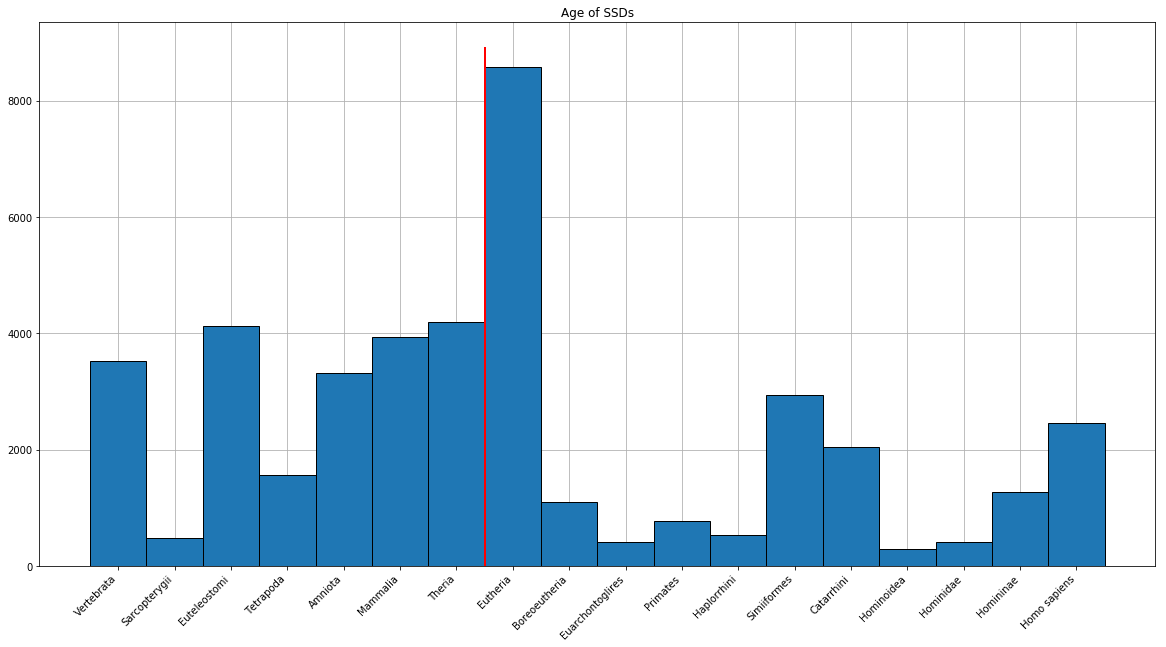

In [118]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(age_list, histtype='bar', bins=np.arange(0,19,1), align='left', ec='k', zorder=20)
ax.xaxis.set_ticks(np.arange(0,18,1))
ax.xaxis.set_ticklabels(vert_list, ha = 'right')
ax.xaxis.set_tick_params(labelrotation = 45)
ax.plot(((np.median(age_list)+0.5), (np.median(age_list)+0.5)), (0,8900),color = 'r', linewidth=2, zorder = 57)
ax.grid(zorder=0)
ax.xaxis.set_label('Time of duplication')
ax.set_title('Age of SSDs')
plt.savefig('SSD_ages.png')
plt.show()

In [129]:
cursor.execute('''SELECT COUNT (DISTINCT id) FROM gene_features WHERE dup_type == "SSD"''')
cursor.fetchall()

[(6115,)]

In [134]:
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN tax_levels TEXT''')
import time
vert_list =  ['Vertebrata', 'Sarcopterygii','Euteleostomi', 'Tetrapoda', 'Amniota', 'Mammalia', 'Theria', 'Eutheria','Boreoeutheria',  'Euarchontoglires', 'Primates', 'Haplorrhini', 'Simiiformes','Catarrhini', 'Hominoidea', 'Hominidae','Homininae', 'Homo sapiens']
cursor.execute('''SELECT id FROM gene_features WHERE dup_type == "SSD"''')
ids = [x[0] for x in cursor.fetchall()]
count, t = 0, time.time()
for i in ids:
    levels = []
    cursor.execute('''SELECT tax_group FROM paralogs WHERE id == ?''', (i,))
    tax_list = [x[0] for x in cursor.fetchall() if x[0] in vert_list]
    for tax in tax_list:
        levels.append(vert_list.index(tax)+1)
    levels = [str(x) for x in levels]
    out = ','.join(levels) + ' '
    cursor.execute('''UPDATE gene_features SET tax_levels = ? WHERE id == ?''', (out, i))
    count += 1
    if count % 150 == 0:
        print(count, 'done:')
        print(time.time()-t, 'seconds since started,')
        print((time.time()-t)/count, 'seconds per gene')
        print(' ')

150 done:
8.038681030273438 seconds since started,
0.05359409332275391 seconds per gene
 
300 done:
16.008821964263916 seconds since started,
0.05336398363113403 seconds per gene
 
450 done:
24.41826105117798 seconds since started,
0.05426377561357286 seconds per gene
 
600 done:
31.94578218460083 seconds since started,
0.053243385155995686 seconds per gene
 
750 done:
39.1982421875 seconds since started,
0.052264942804972334 seconds per gene
 
900 done:
46.86761212348938 seconds since started,
0.05207580672370063 seconds per gene
 
1050 done:
54.06312704086304 seconds since started,
0.051489036196754094 seconds per gene
 
1200 done:
61.69720911979675 seconds since started,
0.051414702534675595 seconds per gene
 
1350 done:
69.9153401851654 seconds since started,
0.0517894623014662 seconds per gene
 
1500 done:
81.03546595573425 seconds since started,
0.05402642599741618 seconds per gene
 
1650 done:
88.91354703903198 seconds since started,
0.05388744123054273 seconds per gene
 
1800 d

In [19]:
import numpy as np
import re, time
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN med_exp REAL''')
count, timer = 0, time.time()
with open('Downloads/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct', 'r') as med_file:
    for i in range(1,4):
        med_file.readline()
    for line in med_file:
        line = line.strip().split('\t')
        gene = re.search(r'(.*)\.(.*)', line[0]).group(1)
        exp = [float(x) for x in line[2:]]
        avg = np.median(exp)
        
        if max(exp) < 1:
            count += 1
        else:
            cursor.execute('''UPDATE gene_features SET med_exp = ? WHERE id == ?''', (avg, gene))
            count += 1
        if count % 1000 == 0:
            print(count, 'done.')
            print(time.time() - timer, 'since started.')
            print((time.time()-timer)/count, 'per gene.')
            print(' ')

1000 done.
9.799201965332031 since started.
0.00979967999458313 per gene.
 
2000 done.
18.057111978530884 since started.
0.009028785467147827 per gene.
 
3000 done.
25.756678104400635 since started.
0.008585681676864625 per gene.
 
4000 done.
35.66995310783386 since started.
0.008917577981948853 per gene.
 
5000 done.
43.878868103027344 since started.
0.008775835609436036 per gene.
 
6000 done.
51.63397693634033 since started.
0.00860573701063792 per gene.
 
7000 done.
59.79907989501953 since started.
0.008542776993342808 per gene.
 
8000 done.
67.70422410964966 since started.
0.008463086634874344 per gene.
 
9000 done.
77.35497498512268 since started.
0.00859505565961202 per gene.
 
10000 done.
86.84640502929688 since started.
0.008684684705734252 per gene.
 
11000 done.
94.54420900344849 since started.
0.008594953905452382 per gene.
 
12000 done.
102.94499611854553 since started.
0.008578785836696625 per gene.
 
13000 done.
110.4056761264801 since started.
0.008492777842741746 per ge

In [20]:
db.commit()

In [4]:
cursor.execute('''SELECT id FROM gene_features WHERE intron_count == 0''')
print(cursor.fetchall())

[('ENSG00000250719',), ('ENSG00000212916',), ('ENSG00000271567',), ('ENSG00000186564',), ('ENSG00000143105',), ('ENSG00000172410',), ('ENSG00000197617',), ('ENSG00000179546',), ('ENSG00000283039',), ('ENSG00000170385',), ('ENSG00000188396',), ('ENSG00000173627',), ('ENSG00000196539',), ('ENSG00000197454',), ('ENSG00000263353',), ('ENSG00000228336',), ('ENSG00000221888',), ('ENSG00000174529',), ('ENSG00000263464',), ('ENSG00000158615',), ('ENSG00000171357',), ('ENSG00000179862',), ('ENSG00000186150',), ('ENSG00000230667',), ('ENSG00000132703',), ('ENSG00000176022',), ('ENSG00000270188',), ('ENSG00000186790',), ('ENSG00000284188',), ('ENSG00000183598',), ('ENSG00000203811',), ('ENSG00000169442',), ('ENSG00000177272',), ('ENSG00000162396',), ('ENSG00000232237',), ('ENSG00000262180',), ('ENSG00000183155',), ('ENSG00000187140',), ('ENSG00000170128',), ('ENSG00000237330',), ('ENSG00000189181',), ('ENSG00000177275',), ('ENSG00000238243',), ('ENSG00000203757',), ('ENSG00000198841',), ('ENSG000

In [23]:
import requests, json
cursor.execute('SELECT trans_id FROM gene_features_all WHERE id ==  "ENSG00000099399"')
t = cursor.fetchall()[0][0]
h = {'Content-Type': 'application/json'}
url = "http://rest.ensembl.org/overlap/id/" + t + "?feature=exon"
r = requests.get(url, headers=h).json()
introns = []
exon_list = []
u_exon_list = []
cursor.execute('''SELECT start,end FROM gene_features WHERE id == ?''', ('ENSG00000099399',))
start, end = cursor.fetchall()[0]
for i in range(0, len(r)):
    if r[i]['Parent'] == t:
        exon_list.append((r[i]['start'], r[i]['end']))
exon_list = sorted(exon_list, key=lambda x: x[0])
for i in range(0, len(exon_list)):
    if i == 0:
        old_start = exon_list[i][0]
        old_end = exon_list[i][1]
    elif i == len(exon_list)-1 and exon_list[i][0] > old_end:#add current interval to list if this is the last value
        u_exon_list.append((old_start, old_end))
        u_exon_list.append((exon_list[i][0], exon_list[i][1]))
    elif (i == len(exon_list)-1) and exon_list[i][0] <= old_end: #if the last entry on the list has a higher end than current interval
        u_exon_list.append((old_start, exon_list[i][1]))
    else:
        if exon_list[i][0] < old_end:
            old_end = exon_list[i][1]
        else:
            u_exon_list.append((old_start, old_end))
            old_start = exon_list[i][0]
            old_end = exon_list[i][1]
print(u_exon_list)
for i in range(0, len(u_exon_list)):
    if i == 0:
        s = start
        if s != u_exon_list[i][0]: #case where there's an intron between gene start and 1st exon start
            introns.append((s,u_exon_list[i][0]))
            next_s = u_exon_list[i][1]
        else:
            next_s = u_exon_list[i][1] #if 1st exon start is gene start, set start of next intron and go to next
    elif i == len(u_exon_list)-1:
        introns.append((next_s, u_exon_list[i][0])) #for last exon, append preceding intron as normal then
        if end != u_exon_list[i][1]: #check for intron between end of last exon and gene end
            introns.append((u_exon_list[i][1], end))
    else:
        introns.append((next_s, u_exon_list[i][0]))
        next_s = u_exon_list[i][1]
print(len(introns))

[(1, 10), (15, 23), (24, 40)]
2


In [28]:
#essentiality
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN ess_1 REAL''')
with open('Downloads/Wang_CRISPR.csv', 'r') as file:
    file.readline()
    for line in file:
        l = line.strip().split(',')
        geneName, KBM7, K562, Jiyoye, Raji = l[0], float(l[2]), float(l[4]), float(l[6]), float(l[8])
        ess = KBM7
        cursor.execute('''UPDATE gene_features SET ess_1 = ? WHERE name == ?''', 
                       (ess, geneName))
        db.commit()

In [32]:
cursor.execute('SELECT ess_1 FROM gene_features WHERE (NOT ess_1 IS NULL) AND dup_type == "WGD"')
w_list = [x[0] for x in cursor.fetchall()]
cursor.execute('SELECT ess_1 FROM gene_features WHERE (NOT ess_1 IS NULL) AND dup_type == "SSD"')
s_list = [x[0] for x in cursor.fetchall()]
from scipy import stats 
stats.mannwhitneyu(w_list, s_list)

MannwhitneyuResult(statistic=10648779.0, pvalue=0.0598315775792419)

In [72]:
with open('Downloads/biogrid_human_interactions.txt', 'r') as file:
    header = file.readline().strip().split('\t')
    line = file.readline().strip().split('\t')

    for i in range(0,len(header)):
        print(i, header[i], ':', line[i])

0 #BioGRID Interaction ID : 103
1 Entrez Gene Interactor A : 6416
2 Entrez Gene Interactor B : 2318
3 BioGRID ID Interactor A : 112315
4 BioGRID ID Interactor B : 108607
5 Systematic Name Interactor A : -
6 Systematic Name Interactor B : -
7 Official Symbol Interactor A : MAP2K4
8 Official Symbol Interactor B : FLNC
9 Synonyms Interactor A : JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAPKK1|SEK1|SERK1|SKK1
10 Synonyms Interactor B : ABP-280|ABP280A|ABPA|ABPL|FLN2|MFM5|MPD4
11 Experimental System : Two-hybrid
12 Experimental System Type : physical
13 Author : Marti A (1997)
14 Pubmed ID : 9006895
15 Organism Interactor A : 9606
16 Organism Interactor B : 9606
17 Throughput : Low Throughput
18 Score : -
19 Modification : -
20 Phenotypes : -
21 Qualifications : -
22 Tags : -
23 Source Database : BIOGRID


In [72]:
import requests, json, time
int_dict = {}
problem_list = []
head = {'Content-Type':'application/json'}
with open('Downloads/biogrid_human_interactions.txt', 'r') as file:
    header = file.readline().strip().split('\t')
    count, t = 0, time.time()
    for line in file:
        ID, ID2 = None, None
        line = line.strip().split('\t')
        if line[12] != 'physical':
            continue   
        elif line[15] != '9606' or line[16] != '9606':
            continue
        else:
            try:
                ID = get_id_from_entrez_id(line[1])
                ID2 = get_id_from_entrez_id(line[2])
                count += 1
            except ValueError:
                continue
        if not(ID and ID2):
            print(line[1], line[2])
        elif not ID:
            print(line[1])
        elif not ID2:
            print(line[2])
        else:
            try:
                int_dict[ID] += 1
            except KeyError:
                int_dict[ID] = 1
            try:
                int_dict[ID] += 1
            except KeyError:
                int_dict[ID] = 1
        if count % 500 == 0 and count != 0:
            print(count, 'done:', time.time()-t, 'seconds in')
        if count/(time.time()-t) > 14:
            time.sleep(1)
            
#maybe just give up and use the database to match up names to ids??

500 done: 169.44456601142883 seconds in
1000 done: 259.15675115585327 seconds in
1500 done: 336.95331621170044 seconds in
2000 done: 419.03894114494324 seconds in
2500 done: 496.74036502838135 seconds in
3000 done: 575.5474061965942 seconds in
3500 done: 655.6971590518951 seconds in
4000 done: 734.3311741352081 seconds in
4500 done: 813.0072431564331 seconds in
5000 done: 893.9380271434784 seconds in
5500 done: 976.319324016571 seconds in
6000 done: 1055.930311203003 seconds in
6500 done: 1137.4131050109863 seconds in
7000 done: 1217.2722010612488 seconds in
7500 done: 1297.6520581245422 seconds in
8000 done: 1378.9635791778564 seconds in
8500 done: 1458.1583180427551 seconds in
9000 done: 1545.0719211101532 seconds in
9500 done: 1624.2135791778564 seconds in
10000 done: 1705.4289751052856 seconds in
10500 done: 1786.9134550094604 seconds in
11000 done: 1867.4830420017242 seconds in
11500 done: 1946.7107532024384 seconds in
12000 done: 2026.6322820186615 seconds in
12500 done: 2107.139

100000 done: 25372.823854207993 seconds in
100500 done: 25752.640269994736 seconds in
101000 done: 25904.536687135696 seconds in
101500 done: 26002.102015018463 seconds in
102000 done: 26096.613166093826 seconds in
102500 done: 26193.03155207634 seconds in
103000 done: 26287.27567100525 seconds in
103500 done: 26381.33799314499 seconds in
104000 done: 26475.235722064972 seconds in
104500 done: 26570.49044919014 seconds in
105000 done: 26662.95664715767 seconds in
105500 done: 26756.03718805313 seconds in
106000 done: 26847.23738718033 seconds in
106500 done: 26937.063172101974 seconds in
107000 done: 27028.097074985504 seconds in
107500 done: 27122.94894504547 seconds in
108000 done: 27218.970719099045 seconds in
108500 done: 27311.084925174713 seconds in
109000 done: 27399.62830710411 seconds in
109500 done: 27499.956856012344 seconds in
110000 done: 27588.471832036972 seconds in
110500 done: 27676.739624023438 seconds in
111000 done: 27763.2965760231 seconds in
111500 done: 27854.942

197000 done: 48303.96384716034 seconds in
197500 done: 48382.661159038544 seconds in
198000 done: 48461.5867869854 seconds in
198500 done: 48540.22635316849 seconds in
199000 done: 48619.40514206886 seconds in
199500 done: 48698.99296998978 seconds in
200000 done: 48778.19217419624 seconds in
200500 done: 48857.37729716301 seconds in
201000 done: 48936.695006132126 seconds in
201500 done: 49014.97808814049 seconds in
202000 done: 49094.273933172226 seconds in
202500 done: 49172.59267807007 seconds in
203000 done: 49252.72162413597 seconds in
203500 done: 49333.16713118553 seconds in
204000 done: 49412.450003147125 seconds in
204500 done: 49492.44078707695 seconds in
205000 done: 49571.3485121727 seconds in
205500 done: 49650.60924100876 seconds in
206000 done: 49729.84805703163 seconds in
206500 done: 49808.29270219803 seconds in
207000 done: 49888.436858177185 seconds in
207500 done: 49968.78303003311 seconds in
208000 done: 50048.18047904968 seconds in
208500 done: 50127.271131038666

294500 done: 63749.70147919655 seconds in
295000 done: 63827.684509038925 seconds in
295500 done: 63906.2622191906 seconds in
296000 done: 63984.596855163574 seconds in
296500 done: 64062.80964112282 seconds in
297000 done: 64140.36874818802 seconds in
297500 done: 64218.48073720932 seconds in
298000 done: 64296.02735900879 seconds in
298500 done: 64373.768334150314 seconds in
299000 done: 64453.7456882 seconds in
299500 done: 64533.08526110649 seconds in
300000 done: 64612.42749500275 seconds in
300500 done: 64691.07411503792 seconds in
301000 done: 64769.16986703873 seconds in
301500 done: 64848.26054215431 seconds in
302000 done: 64925.79348897934 seconds in
302500 done: 65006.38874411583 seconds in
303000 done: 65089.097038030624 seconds in
303500 done: 65169.59868502617 seconds in
304000 done: 65247.29194998741 seconds in
304500 done: 65327.333948135376 seconds in
305000 done: 65407.03395104408 seconds in
305500 done: 65485.916540145874 seconds in
306000 done: 65564.25748205185 se

In [122]:
def get_id_from_entrez_id(entrez_id):
    
    import requests, json, sqlite3
    from requests import ConnectTimeout, ReadTimeout
    db = sqlite3.connect('./database')
    db.isolation_level = None
    cursor = db.cursor()
    
    head = {'Content-Type':'application/json'}
    url = 'http://rest.ensembl.org/xrefs/name/human/' + entrez_id + '?external_db=EntrezGene'
    try:
        r = requests.get(url, headers=head, timeout = 5)
    except (ConnectTimeout, ReadTimeout) as e:
        raise RuntimeError('timed out')
    try:
        r = r.json()
    except ValueError:
        raise RuntimeError('request failed')
    
    if len(r) != 1:
        
        if len(r) > 1:
            raise ValueError('Multiple results:', entrez_id)

        else:
            raise LookupError('Query returned empty:', entrez_id)
    else:
        cursor.execute('''SELECT id FROM gene_features WHERE name == ?''', (r[0]['display_id'],))
        try:
            return(cursor.fetchall()[0][0])
        except IndexError:
            return(None)
        

In [73]:
db.commit()

In [77]:
import time
# cursor.execute('''ALTER TABLE gene_features ADD COLUMN PPIs INTEGER''')
count, t = 0, time.time()
for k in int_dict:
    cursor.execute('''UPDATE gene_features SET PPIs = ? WHERE id == ?''', (int_dict[k], k))
    count += 1
    if count % 500 == 0:
        print(count, round(time.time()-t,2), 'seconds')

500 6.82 seconds
1000 13.72 seconds
1500 20.87 seconds
2000 27.5 seconds
2500 34.31 seconds
3000 41.02 seconds
3500 47.81 seconds
4000 54.61 seconds
4500 61.46 seconds
5000 68.22 seconds
5500 75.02 seconds
6000 81.69 seconds
6500 88.46 seconds
7000 96.14 seconds
7500 103.11 seconds
8000 110.03 seconds
8500 116.93 seconds
9000 124.35 seconds
9500 131.89 seconds
10000 139.58 seconds
10500 146.77 seconds
11000 154.22 seconds
11500 161.07 seconds
12000 168.82 seconds
12500 175.67 seconds
13000 183.1 seconds


In [80]:
cursor.execute('''UPDATE gene_features SET PPIs = 0 WHERE PPIs IS NULL''')
db.commit()

In [123]:
cursor.execute('''UPDATE gene_features SET PPIs = NULL''')
with open('Downloads/biogrid_human_interactions.txt', 'r') as file:
    count, t = 0, time.time()
    int_list, fail_list = [], []
    file.readline()
    multi_list, empty_list = [],[]
    print('Creating list:')
    for line in file:
        success = False
        t0 = time.time()
        line = line.strip().split('\t')
        if line[12] != 'physical':
            continue   
        elif line[15] != '9606' or line[16] != '9606':
            continue
        else:
            try:
                id1 = get_id_from_entrez_id(line[1])
                int_list.append(id1)
            except ValueError:
                multi_list.append(line[1])
            except LookupError:
                empty_list.append(line[1])
            except RuntimeError:
                fail_list.append(line[1])
           
            try:
                id2 = get_id_from_entrez_id(line[2])
                int_list.append(id2)
            except ValueError:
                multi_list.append(line[2])
            except LookupError:
                empty_list.append(line[2])
            except RuntimeError:
                fail_list.append(line[2])
            count += 1
        
        if count % 1000 == 0:
            print(count, 'done:', round(time.time()-t,2), 'seconds')
            
    print('retrying failed requests...', len(fail_list))
    while fail_list != []:
        for i in fail_list:
            try:
                id1 = get_id_from_entrez_id(i)
                int_list.append(id1)
                fail_list.remove(i)
            except ValueError:
                multi_list.append(i)
                fail_list.remove(i)
            except LookupError:
                empty_list.append(i)
                fail_list.remove(i)
            except RuntimeError:
                continue
cursor.execute('''SELECT id FROM gene_features''')
id_list = [x[0] for x in cursor.fetchall()]
print('Updating table:')
count, t = 0, time.time()
for i in id_list:
    cursor.execute('''UPDATE gene_features SET PPIs = ? WHERE id == ?''', (int_list.count(i), i))
    count += 1
    if count % 500 == 0:
        print(count, 'done:', round(time.time()-t, 2), 'seconds')

Creating list:
1000 done: 168.01 seconds
2000 done: 333.78 seconds
3000 done: 492.01 seconds
4000 done: 650.09 seconds
5000 done: 810.61 seconds
6000 done: 969.63 seconds
7000 done: 1134.85 seconds
8000 done: 1296.15 seconds
9000 done: 1455.5 seconds
10000 done: 1609.94 seconds
11000 done: 1771.7 seconds
12000 done: 1930.23 seconds
13000 done: 2089.19 seconds
14000 done: 2247.27 seconds
15000 done: 2402.84 seconds
16000 done: 2568.38 seconds
17000 done: 2734.77 seconds
18000 done: 2896.03 seconds
19000 done: 3053.14 seconds
20000 done: 3228.0 seconds
21000 done: 3385.85 seconds
22000 done: 3547.47 seconds
23000 done: 3705.64 seconds
24000 done: 3868.51 seconds
25000 done: 4028.91 seconds
26000 done: 4188.23 seconds
27000 done: 4347.04 seconds
28000 done: 4505.74 seconds
29000 done: 4663.79 seconds
30000 done: 4821.14 seconds
31000 done: 5031.03 seconds
32000 done: 5192.95 seconds
33000 done: 5353.59 seconds
34000 done: 5510.7 seconds
35000 done: 5667.98 seconds
36000 done: 5824.12 seco

281000 done: 46703.86 seconds
282000 done: 46862.66 seconds
283000 done: 47040.55 seconds
284000 done: 47218.55 seconds
285000 done: 47411.34 seconds
286000 done: 47593.12 seconds
287000 done: 47788.32 seconds
288000 done: 47954.76 seconds
289000 done: 48121.04 seconds
290000 done: 48299.23 seconds
291000 done: 48488.71 seconds
292000 done: 48667.47 seconds
293000 done: 48829.89 seconds
294000 done: 48998.54 seconds
295000 done: 49172.54 seconds
296000 done: 49346.83 seconds
297000 done: 49512.36 seconds
298000 done: 49673.0 seconds
299000 done: 49832.48 seconds
300000 done: 49989.18 seconds
301000 done: 50147.23 seconds
302000 done: 50304.04 seconds
303000 done: 50457.22 seconds
304000 done: 50613.05 seconds
305000 done: 50770.7 seconds
306000 done: 50927.52 seconds
307000 done: 51084.02 seconds
308000 done: 51243.52 seconds
309000 done: 51401.33 seconds
310000 done: 51555.64 seconds
311000 done: 51714.09 seconds
312000 done: 51876.76 seconds
313000 done: 52034.76 seconds
314000 done:

In [121]:
from requests import ConnectTimeout, ReadTimeout
try:
    r = requests.get(url, headers={'Content-Type':'application/json'}, timeout=0.001)
    print(r.json())
except (ConnectTimeout, ReadTimeout) as e:
    print('Caught the timeout!')


Caught the timeout!


In [ ]:
db.commit()